<a href="https://colab.research.google.com/github/OliverTororo/network-intrusion-hybrid-ml-dl/blob/main/ids_hybrid_pipeline_colab_MalMem2022_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IDS Hybrid Pipeline — v5 (Colab)

**Datasets**: KDD‑CUP99 (binary/multiclass), CIC‑IDS2017 (binary/multiclass), CIC‑MalMem‑2022 (binary)

Incluye:
- Montaje de Google Drive y **salida en** `Mi unidad/Colab Notebooks/ids_pipeline/<DATASET_MODE>/`.
- Lectura directa desde tus rutas (`Datasets/...`).
- **Selección de modelos a ejecutar** (ML/DL por listas).
- **SMOTE antes y después** (gráfico de distribución por clase / barras).
- **XGBoost** para importancia y **selección de top‑k**; tabla y gráfico Top‑20.
- **Métricas** (Accuracy, Precision, Recall, F1, AUC), **Matriz de confusión**, **Curvas ROC**.
- **Checkpoints**: ML (`.joblib`) y DL (`.keras`), reanudables.
- **Mixed precision** + *batch size* dinámico en GPU (T4/L4/A100).

Metodología alineada con tu pipeline inicial y con Talukder et al. (2023).


## 0) Entorno: Montar Drive y rutas

In [29]:
# 0) Entorno: detectar Colab, montar Drive y definir rutas base
import os

IN_COLAB = False
try:
    import google.colab  # type: ignore
    IN_COLAB = True
except Exception:
    IN_COLAB = False

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    OUT_ROOT = '/content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote'
    DATA_ROOT = '/content/drive/MyDrive/Colab Notebooks/Datasets'
    print("✅ Drive montado en /content/drive")
else:
    OUT_ROOT = os.path.abspath('./ids_pipeline')
    DATA_ROOT = os.path.abspath('./Datasets')
    print("⚠️ No estás en Colab; usando rutas locales.")

for p in (OUT_ROOT, DATA_ROOT):
    os.makedirs(p, exist_ok=True)

print("📁 OUT_ROOT:", OUT_ROOT)
print("📁 DATA_ROOT:", DATA_ROOT)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Drive montado en /content/drive
📁 OUT_ROOT: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote
📁 DATA_ROOT: /content/drive/MyDrive/Colab Notebooks/Datasets


## 1) Setup automático



In [30]:
%%bash
python -V
echo "🔧 Limpiando dependencias conflictivas de Colab…"

# 0) Desinstalar paquetes que chocan con nuestro stack
python -m pip -q uninstall -y \
  jax jaxlib flax optax orbax-checkpoint \
  tensorflow-text tensorflow-decision-forests tf-keras tensorstore pytensor || true

# 1) Actualizar herramientas base
python -m pip -q install --upgrade pip setuptools wheel

echo "📦 Instalando stack base (TF 2.18 + NumPy 1.26.x)…"
python -m pip -q install --no-cache-dir \
  "tensorflow==2.18.0" "keras==3.6.0" \
  "numpy==1.26.4" "pandas==2.2.2" "matplotlib==3.8.4" "seaborn==0.13.2"

echo "📦 Instalando librerías de ML…"
python -m pip -q install --no-cache-dir \
  "scikit-learn==1.5.2" "imbalanced-learn==0.12.3" \
  "xgboost==2.1.1" "lightgbm==4.3.0" "catboost==1.2.5"

# 2) Reparar ml_dtypes para que JAX no moleste
echo "🔧 Corrigiendo ml_dtypes…"
python -m pip -q install --no-cache-dir "ml_dtypes==0.5.0"

echo "✅ Setup de dependencias v4.3.1 completado."


Python 3.12.12
🔧 Limpiando dependencias conflictivas de Colab…
📦 Instalando stack base (TF 2.18 + NumPy 1.26.x)…
📦 Instalando librerías de ML…
🔧 Corrigiendo ml_dtypes…
✅ Setup de dependencias v4.3.1 completado.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-hub 0.21.1 requires tensorflow-text; platform_system != "Windows", which is not installed.
dopamine-rl 4.1.2 requires flax>=0.2.0, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installed.
dopamine-rl 4.1.2 requires tf-keras>=2.18.0, which is not installed.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
keras-hub 0.21.1 requires tensorflow-text; platform_system != "Windows", which is not installed.
dopamine-rl 4.1.2 requires flax>=0.2.0, which is not installed.
dopamine-rl 4.1.2 requires jax>=0.1.72, which is not installed.
dopamine-rl 4.1.2 requires jaxlib>=0.1.51, which is not installe

In [31]:
import sys, numpy as np, tensorflow as tf, sklearn
import xgboost, lightgbm, catboost

print("Python :", sys.version)
print("NumPy  :", np.__version__)
print("TF     :", tf.__version__)
print("SKL    :", sklearn.__version__)
print("XGB    :", xgboost.__version__)
print("LGBM   :", lightgbm.__version__)
print("CatB   :", catboost.__version__)
print("✅ Entorno de dependencias listo.")


Python : 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
NumPy  : 1.26.4
TF     : 2.18.0
SKL    : 1.5.2
XGB    : 2.1.1
LGBM   : 4.3.0
CatB   : 1.2.5
✅ Entorno de dependencias listo.


## 2) Configuración: Dataset, modo y selección de modelos

In [32]:
# 2) Configuración del experimento (dataset, modo, modelos, rutas)

import os

# DATASET: 'KDD', 'CICIDS2017', 'MalMem2022'
DATASET = 'MalMem2022'          # <-- cámbialo a 'CICIDS2017' o 'MalMem2022'
TASK_MODE = 'binary'     # 'binary' o 'multiclass' (MalMem2022 solo 'binary')

# Qué tipo de modelos ejecutar
RUN_ML = True
RUN_DL = True

# 🔧 Modo de SMOTE:
#   "dynamic" -> SMOTE Inteligente (actual)
#   "full"    -> SMOTE completo estilo paper (todas las clases hacia la mayoritaria)
#   "none"    -> sin SMOTE
SMOTE_MODE = "full"   # "dynamic" o "full" o "none"

# Modelos de Machine Learning
ML_TO_RUN = ['RF', 'DT', 'KNN', 'MLP', 'LightGBM', 'CatBoost'] # ['RF', 'DT', 'KNN', 'MLP', 'LightGBM', 'CatBoost']

# Modelos de Deep Learning
DL_TO_RUN = ['ANN', 'CNN1D', 'LSTM', 'AE_LR']  # ['ANN', 'CNN1D', 'LSTM', 'AE_LR'] Autoencoder + Logistic Regression

# Rutas de datasets en tu Drive (como me los pasaste)
KDD_FILE    = f"{DATA_ROOT}/KDD-CUP99/kddcup.data_10_percent.csv"
CIC_DIR     = f"{DATA_ROOT}/CIC-IDS2017"
MALMEM_FILE = f"{DATA_ROOT}/MalMem2022/MalMem2022.csv"

# Nombre de etiqueta esperado por dataset
LABEL_COLS = {
    'KDD': 'label',
    'CICIDS2017': 'Label',
    'MalMem2022': 'Class',
}

LABEL_COL = LABEL_COLS[DATASET]

# Identificador de corrida
RUN_TAG = f"{DATASET}_{TASK_MODE}"

# Carpetas de salida
RUN_DIR = os.path.join(OUT_ROOT, RUN_TAG)
FIG_DIR = os.path.join(RUN_DIR, "figs")
REP_DIR = os.path.join(RUN_DIR, "reports")
CKPT_DIR = os.path.join(RUN_DIR, "checkpoints")

for d in (RUN_DIR, FIG_DIR, REP_DIR, CKPT_DIR):
    os.makedirs(d, exist_ok=True)

print(f"🎯 DATASET: {DATASET}")
print(f"🎯 TASK_MODE: {TASK_MODE}")
print(f"⚙️ SMOTE_MODE = {SMOTE_MODE}")
print(f"📂 RUN_DIR: {RUN_DIR}")
print(f"📂 FIG_DIR: {FIG_DIR}")
print(f"📂 REP_DIR: {REP_DIR}")
print(f"📂 CKPT_DIR: {CKPT_DIR}")

🎯 DATASET: MalMem2022
🎯 TASK_MODE: binary
⚙️ SMOTE_MODE = full
📂 RUN_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary
📂 FIG_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs
📂 REP_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports
📂 CKPT_DIR: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints


## 3) Utilidades (guardado, plots, reporte)

In [33]:
# 3) Utilidades (guardado, plots, reporte, logging) — v4.3.1

import gc, time, json, numpy as np, pandas as pd, os, datetime
from pathlib import Path
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support, confusion_matrix,
    roc_auc_score, roc_curve, auc
)
from contextlib import contextmanager

LOG_PATH = os.path.join(RUN_DIR, "log.txt")

def _append_log(msg: str):
    ts = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    line = f"[{ts}] {msg}"
    print(msg)
    os.makedirs(os.path.dirname(LOG_PATH), exist_ok=True)
    with open(LOG_PATH, "a", encoding="utf-8") as f:
        f.write(line + "\n")

@contextmanager
def timed_block(name: str):
    _append_log(f"▶️ Inicio bloque {name}")
    t0 = time.time()
    try:
        yield
    finally:
        dt = time.time() - t0
        _append_log(f"⏱ Fin bloque {name} (duración: {dt:.2f} s)")

def save_json(obj, path):
    with open(path, 'w', encoding="utf-8") as f:
        json.dump(obj, f, indent=2)

def load_json(path):
    with open(path, 'r', encoding="utf-8") as f:
        return json.load(f)

def show_and_save_current_fig(fig_path, dpi=150):
    os.makedirs(os.path.dirname(fig_path), exist_ok=True)
    plt.tight_layout()
    plt.savefig(fig_path, dpi=dpi, bbox_inches='tight')
    plt.show()
    _append_log(f"📊 Gráfico guardado en: {fig_path}")

def save_and_display_table(df, path, note=None):
    os.makedirs(os.path.dirname(path), exist_ok=True)
    df.to_csv(path, index=False)
    display(df)
    msg = f"📄 Tabla guardada en: {path}"
    if note:
        msg += f" — {note}"
    _append_log(msg)

def free_mem(*vs):
    for v in vs:
        try:
            del v
        except Exception:
            pass
    gc.collect()

CKPT_META = os.path.join(CKPT_DIR, 'meta.json')
if not os.path.exists(CKPT_META):
    save_json({'models': {}}, CKPT_META)

def record_model(name, path):
    meta = load_json(CKPT_META)
    meta['models'][name] = path
    save_json(meta, CKPT_META)

REPORT_PATH = os.path.join(REP_DIR, f'summary_{RUN_TAG}.json')
if not os.path.exists(REPORT_PATH):
    save_json({'run': RUN_TAG, 'results': []}, REPORT_PATH)

def log_result(entry):
    rep = load_json(REPORT_PATH)
    rep['results'].append(entry)
    save_json(rep, REPORT_PATH)

_append_log("✅ Utilidades cargadas.")


✅ Utilidades cargadas.


## 4) Carga de datos (por dataset) + limpieza básica

In [34]:
# 4) Carga de datos por dataset + verificación de LABEL_COL

import pandas as pd, glob

def _standardize_columns(df):
    df.columns = (
        df.columns.astype(str)
        .str.replace('\ufeff', '', regex=False)
        .str.strip()
        .str.replace(r'\s+', ' ', regex=True)
    )
    return df

def load_kdd(path: str) -> pd.DataFrame:
    _append_log(f"📥 Cargando KDD desde: {path}")
    df = pd.read_csv(path, header=None, low_memory=False)
    df.columns = [*(f"f{i}" for i in range(df.shape[1]-1)), "label"]
    return _standardize_columns(df)

def concat_cic(dir_like: str, chunksize: int = 200_000) -> pd.DataFrame:
    _append_log(f"📥 Concatenando archivos CIC-IDS2017 desde: {dir_like}")
    order = [
        "Monday-WorkingHours.pcap_ISCX.csv","Tuesday-WorkingHours.pcap_ISCX.csv",
        "Wednesday-workingHours.pcap_ISCX.csv","Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv",
        "Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv","Friday-WorkingHours-Morning.pcap_ISCX.csv",
        "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv","Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",
    ]
    files = [os.path.join(dir_like, f) for f in order if os.path.exists(os.path.join(dir_like, f))]
    if not files:
        files = sorted(glob.glob(os.path.join(dir_like, "*.csv")))
    if not files:
        raise FileNotFoundError("No se encontraron CSV en la carpeta CIC-IDS2017")
    dfs = []
    for f in files:
        _append_log(f"  ├─ {os.path.basename(f)}")
        for ch in pd.read_csv(f, chunksize=chunksize, low_memory=False):
            dfs.append(_standardize_columns(ch))
    return _standardize_columns(pd.concat(dfs, ignore_index=True))

def _detect_label_col(df: pd.DataFrame, expected: str) -> str:
    if expected in df.columns:
        return expected
    for c in df.columns:
        if c.strip().casefold() in {"label", "class"}:
            return c
    raise KeyError(f"No se encontró columna de etiqueta. Columnas: {list(df.columns)[:20]}")

def normalize_cic_labels(df: pd.DataFrame, label_col: str) -> pd.DataFrame:
    df[label_col] = df[label_col].astype(str).str.strip()
    mapping = {
        "Web Attack - Brute Force": "Web Attack – Brute Force",
        "Web Attack - XSS": "Web Attack – XSS",
        "Web Attack - Sql Injection": "Web Attack – Sql Injection",
        "BENIGN ": "BENIGN",
    }
    df[label_col] = df[label_col].map(lambda x: mapping.get(x, x))
    return df

with timed_block("4 - Carga de datos"):
    if DATASET == "KDD":
        assert os.path.exists(KDD_FILE), "Sube kddcup.data_10_percent.csv a la ruta indicada"
        df_raw = load_kdd(KDD_FILE)
        LABEL_COL = "label"
    elif DATASET == "CICIDS2017":
        df_raw = concat_cic(CIC_DIR, chunksize=200_000)
        LABEL_COL = _detect_label_col(df_raw, LABEL_COLS["CICIDS2017"])
        df_raw = normalize_cic_labels(df_raw, LABEL_COL)
    else:  # MalMem2022
        assert os.path.exists(MALMEM_FILE), "Sube MalMem2022.csv a la ruta indicada"
        _append_log(f"📥 Cargando MalMem2022 desde: {MALMEM_FILE}")
        df_raw = pd.read_csv(MALMEM_FILE, low_memory=False)
        df_raw = _standardize_columns(df_raw)
        LABEL_COL = _detect_label_col(df_raw, LABEL_COLS["MalMem2022"])

    print("📐 df_raw shape:", df_raw.shape)
    display(df_raw.head())

    # Verificación de columna de etiqueta
    print(f"📋 Columnas totales: {len(df_raw.columns)}")
    print(f"🎯 Columna de etiqueta esperada/detectada: '{LABEL_COL}'")

    if LABEL_COL not in df_raw.columns:
        print("⚠️ No se encontró la columna esperada. Últimas 10 columnas:")
        print(list(df_raw.columns[-10:]))
    else:
        print("✅ Columna de etiqueta encontrada.")
        uniques = pd.Series(df_raw[LABEL_COL].astype(str).unique())
        print("Ejemplos de valores:", list(uniques[:10]))
        print("📦 Conteo (primeros 20):")
        display(df_raw[LABEL_COL].value_counts().head(20))


▶️ Inicio bloque 4 - Carga de datos
📥 Cargando MalMem2022 desde: /content/drive/MyDrive/Colab Notebooks/Datasets/MalMem2022/MalMem2022.csv
📐 df_raw shape: (58596, 58)


,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,handles.nfile,handles.nevent,handles.ndesktop,handles.nkey,handles.nthread,handles.ndirectory,handles.nsemaphore,handles.ntimer,handles.nsection,handles.nmutant,ldrmodules.not_in_load,ldrmodules.not_in_init,ldrmodules.not_in_mem,ldrmodules.not_in_load_avg,ldrmodules.not_in_init_avg,ldrmodules.not_in_mem_avg,malfind.ninjections,malfind.commitCharge,malfind.protection,malfind.uniqueInjections,psxview.not_in_pslist,psxview.not_in_eprocess_pool,psxview.not_in_ethread_pool,psxview.not_in_pspcid_list,psxview.not_in_csrss_handles,psxview.not_in_session,psxview.not_in_deskthrd,psxview.not_in_pslist_false_avg,psxview.not_in_eprocess_pool_false_avg,psxview.not_in_ethread_pool_false_avg,psxview.not_in_pspcid_list_false_avg,psxview.not_in_csrss_handles_false_avg,psxview.not_in_session_false_avg,psxview.not_in_deskthrd_false_avg,modules.nmodules,svcscan.nservices,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,Class,Category,Filename
0,45,17,10.555556,0,202.844444,1694,38.500000,9129,212.302326,0,670,3161,46,716,887,104,671,125,184,257,53,95,53,0.030372,0.054441,0.030372,5,21,30,1.250000,2,0,3,2,7,4,9,0.042553,0.0,0.063830,0.042553,0.148936,0.085106,0.191489,138,389,221,26,24,116,0,121,87,0,8,Benign,Benign,Benign
1,47,19,11.531915,0,242.234043,2074,44.127660,11385,242.234043,0,840,3761,51,1011,1030,117,766,148,337,394,77,123,77,0.036167,0.057774,0.036167,12,77,72,1.714286,0,0,0,0,4,2,6,0.000000,0.0,0.000000,0.000000,0.085106,0.042553,0.127660,138,392,222,26,24,118,0,122,87,0,8,Benign,Benign,Benign
2,40,14,14.725000,0,288.225000,1932,48.300000,11529,288.225000,0,1050,3996,45,784,1241,100,645,138,369,338,51,89,51,0.026114,0.045571,0.026114,5,6,30,1.250000,0,0,0,0,4,2,5,0.000000,0.0,0.000000,0.000000,0.100000,0.050000,0.125000,137,395,222,26,27,118,0,120,88,0,8,Benign,Benign,Benign
3,32,13,13.500000,0,264.281250,1445,45.156250,8457,264.281250,0,630,2961,36,654,792,83,567,127,186,242,31,62,31,0.021483,0.042966,0.021483,2,2,12,1.000000,0,0,0,0,4,2,6,0.000000,0.0,0.000000,0.000000,0.125000,0.062500,0.187500,138,395,222,26,27,118,0,120,88,0,8,Benign,Benign,Benign
4,42,16,11.452381,0,281.333333,2067,49.214286,11816,281.333333,0,908,3834,45,1252,942,103,825,135,375,429,102,143,102,0.047820,0.067042,0.047820,12,77,72,2.000000,4,0,4,4,8,6,10,0.086957,0.0,0.086957,0.086957,0.173913,0.130435,0.217391,138,392,222,26,24,118,0,124,87,0,8,Benign,Benign,Benign


📋 Columnas totales: 58
🎯 Columna de etiqueta esperada/detectada: 'Class'
✅ Columna de etiqueta encontrada.
Ejemplos de valores: ['Benign', 'Malware']
📦 Conteo (primeros 20):


,count
Class,
Benign,29298
Malware,29298


⏱ Fin bloque 4 - Carga de datos (duración: 0.58 s)


## 5) Preparación, codificación, split + **distribución por clase** (antes de SMOTE)

▶️ Inicio bloque 5 - Preprocesamiento y distribución inicial (Before SMOTE)
🔄 Iniciando preprocesamiento…
🪪 MalMem2022 (binaria): Benign vs Malware.
📐 X shape: (58596, 55), y shape: (58596,)
⏱ Fin bloque 5 - Preprocesamiento y distribución inicial (Before SMOTE) (duración: 0.08 s)


,Class,Count
0,Benign,29298
1,Malware,29298


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/class_dist_before_MalMem2022_binary.csv — Distribución de clases antes de SMOTE


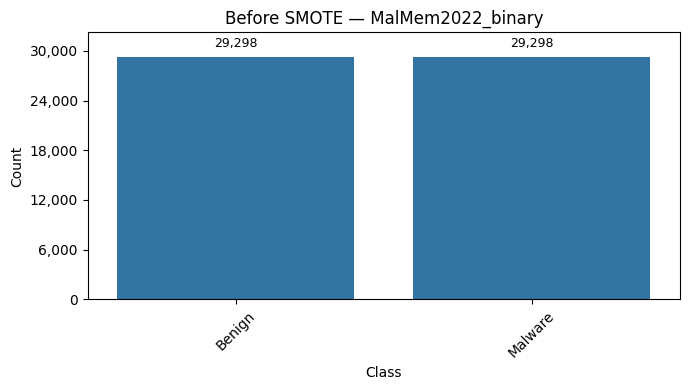

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_before_smote_MalMem2022_binary.png
✅ Bloque 5 completado (Before SMOTE).


In [35]:
## 5) Preparación y distribución **antes de SMOTE** — v4.3.4

from sklearn.preprocessing import LabelEncoder
from matplotlib.ticker import MaxNLocator, StrMethodFormatter

with timed_block("5 - Preprocesamiento y distribución inicial (Before SMOTE)"):
    _append_log("🔄 Iniciando preprocesamiento…")

    df = df_raw.copy()

    # 1) Definir target según DATASET y TASK_MODE
    if DATASET == 'CICIDS2017':
        # Normalizar etiqueta original
        df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

        # === AGRUPACIÓN OFICIAL CIC-IDS2017: 15 etiquetas → 9 tipos de ataque ===
        attack_map_cic = {
            'BENIGN': 'BENIGN',
            'DDoS': 'DDoS',
            'DoS Hulk': 'DoS',
            'DoS GoldenEye': 'DoS',
            'DoS slowloris': 'DoS',
            'DoS Slowhttptest': 'DoS',
            'PortScan': 'Port Scan',
            'FTP-Patator': 'Brute Force',
            'SSH-Patator': 'Brute Force',
            'Bot': 'Bot',
            'Web Attack � Brute Force': 'Web Attack',
            'Web Attack � XSS': 'Web Attack',
            'Web Attack � Sql Injection': 'Web Attack',
            'Web Attack – Brute Force': 'Web Attack',
            'Web Attack – XSS': 'Web Attack',
            'Web Attack – Sql Injection': 'Web Attack',
            'Web Attack - Brute Force': 'Web Attack',
            'Web Attack - XSS': 'Web Attack',
            'Web Attack - Sql Injection': 'Web Attack',
            'Infiltration': 'Infiltration',
            'Heartbleed': 'Heartbleed'
        }

        df["AttackType"] = df[LABEL_COL].map(attack_map_cic)

        before_rows = len(df)
        df = df[~df["AttackType"].isna()].copy()
        after_rows = len(df)
        _append_log(f"🧮 CICIDS2017: filas antes del mapeo AttackType={before_rows}, después={after_rows}")

        if TASK_MODE == 'binary':
            df['target'] = (df["AttackType"] != "BENIGN").astype(int)
            class_names = ['BENIGN', 'ATTACK']
            label_map = {0: 'BENIGN', 1: 'ATTACK'}
            _append_log("🪪 CICIDS2017 (binaria) usando AttackType (BENIGN vs ATTACK).")
        else:
            le = LabelEncoder()
            df['target'] = le.fit_transform(df["AttackType"])
            class_names = list(le.classes_)
            label_map = {i: c for i, c in enumerate(class_names)}
            _append_log(f"🪪 CICIDS2017 multiclase (grupos agregados): {class_names}")
            _append_log("📦 Distribución de AttackType (CIC, grupos):")
            display(df["AttackType"].value_counts())

    elif DATASET == 'KDD':
        # -------------------------------------------
        # 0) Asignar nombres reales a las features KDD
        # -------------------------------------------
        _append_log("🔧 KDD: asignando nombres reales de features KDD CUP'99…")

        kdd_feature_names = [
            'duration', 'protocol_type', 'service', 'flag',
            'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
            'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
            'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
            'num_shells', 'num_access_files', 'num_outbound_cmds',
            'is_host_login', 'is_guest_login', 'count', 'srv_count',
            'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate',
            'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
            'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
            'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
            'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
            'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
            'dst_host_srv_rerror_rate'
        ]

        # Columnas que actualmente son features (ej. f0..f40) = todas menos LABEL_COL
        feature_cols_raw = [c for c in df.columns if c != LABEL_COL]

        if len(feature_cols_raw) != 41:
            _append_log(
                f"⚠️ Advertencia KDD: se esperaban 41 columnas de features y se encontraron {len(feature_cols_raw)}. "
                "Se intentará renombrar parcialmente (zip corto)."
            )

        # Mapear nombres originales (f0,f1,...) → nombres reales de KDD
        col_map = dict(zip(feature_cols_raw, kdd_feature_names))
        df.rename(columns=col_map, inplace=True)

        _append_log("✅ Nombres reales asignados a las columnas de features KDD.")
        _append_log(f"🔎 Primeras columnas KDD: {df.columns.tolist()[:10]}")

        # -------------------------------------------
        # 1) Normalizar etiquetas de KDD (label)
        # -------------------------------------------
        df[LABEL_COL] = (
            df[LABEL_COL]
            .astype(str)
            .str.strip()
            .str.lower()
            .str.rstrip('.')        # <--- quita el "." final si lo hay
        )

        _append_log("🔎 Ejemplos de etiquetas crudas (KDD) tras limpieza:")
        display(df[LABEL_COL].value_counts().head(15))

        # -------------------------------------------
        # 2) Conversión numérica unificada de features
        # -------------------------------------------
        _append_log("🔧 KDD: convirtiendo todas las features a numérico (errors='coerce')…")
        df[LABEL_COL] = df[LABEL_COL].astype(str)

        feat_cols_kdd = [c for c in df.columns if c != LABEL_COL]
        df[feat_cols_kdd] = df[feat_cols_kdd].apply(pd.to_numeric, errors="coerce")
        df[feat_cols_kdd] = df[feat_cols_kdd].fillna(0)

        _append_log("✅ Conversión numérica KDD completada (ejemplo dtypes):")
        display(df[feat_cols_kdd].dtypes.head())

        if TASK_MODE == 'binary':
            # normal vs cualquier otro ataque
            df['target'] = (df[LABEL_COL] != 'normal').astype(int)
            class_names = ['normal', 'attack']
            label_map = {0: 'normal', 1: 'attack'}
            _append_log("🪪 KDD (binaria): normal vs attack (labels normal / !=normal).")

        else:
            # --- Mapeo a 5 superclases: DoS, Normal, Probe, R2L, U2R ---
            kdd_attack_map_clean = {
                # Normal
                'normal': 'Normal',

                # DoS
                'back': 'DoS',
                'land': 'DoS',
                'neptune': 'DoS',
                'pod': 'DoS',
                'smurf': 'DoS',
                'teardrop': 'DoS',
                'apache2': 'DoS',
                'mailbomb': 'DoS',
                'processtable': 'DoS',
                'udpstorm': 'DoS',

                # Probe
                'ipsweep': 'Probe',
                'nmap': 'Probe',
                'portsweep': 'Probe',
                'satan': 'Probe',
                'mscan': 'Probe',
                'saint': 'Probe',

                # R2L
                'ftp_write': 'R2L',
                'guess_passwd': 'R2L',
                'http_tunnel': 'R2L',
                'imap': 'R2L',
                'multihop': 'R2L',
                'named': 'R2L',
                'phf': 'R2L',
                'sendmail': 'R2L',
                'snmpgetattack': 'R2L',
                'snmpguess': 'R2L',
                'spy': 'R2L',
                'warezclient': 'R2L',
                'warezmaster': 'R2L',

                # U2R
                'buffer_overflow': 'U2R',
                'loadmodule': 'U2R',
                'perl': 'U2R',
                'rootkit': 'U2R',
                'ps': 'U2R',
                'xterm': 'U2R',
                'sqlattack': 'U2R'
            }

            df['AttackType'] = df[LABEL_COL].map(kdd_attack_map_clean)

            before_rows = len(df)
            df = df[~df['AttackType'].isna()].copy()
            after_rows = len(df)
            _append_log(
                f"🧮 KDD multiclase: filas antes del mapeo={before_rows}, después={after_rows}"
            )

            if after_rows == 0:
                raise ValueError(
                    "❌ Ninguna etiqueta de KDD pudo mapearse a AttackType.\n"
                    "Revisa los valores únicos de la columna de etiqueta que se mostraron arriba."
                )

            # Orden de clases EXACTAMENTE como en el paper
            class_order = ['DoS', 'Normal', 'Probe', 'R2L', 'U2R']
            class_to_id = {c: i for i, c in enumerate(class_order)}  # DoS->0, Normal->1,...

            df['target'] = df['AttackType'].map(class_to_id).astype(int)

            class_names = class_order
            label_map   = {i: c for i, c in enumerate(class_order)}

            _append_log(
                f"🪪 KDD (multiclase): AttackType → {class_order} con codificación 0–4 según el paper."
            )
            _append_log("📦 Distribución de AttackType (KDD, 5 clases):")
            display(df['AttackType'].value_counts())

    else:  # MalMem2022 (binario)
        if df[LABEL_COL].dtype == 'object':
            df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip().str.lower()
            df['target'] = (df[LABEL_COL] != 'benign').astype(int)
        else:
            df['target'] = df[LABEL_COL].astype(int)
        class_names = ['Benign', 'Malware']
        label_map = {0: 'Benign', 1: 'Malware'}
        _append_log("🪪 MalMem2022 (binaria): Benign vs Malware.")

    # 2) Construir X numérico e y
    y = df['target'].astype(int).values
    X = (
        df.drop(columns=['target', LABEL_COL, 'AttackType'], errors='ignore')
          .select_dtypes(include=['number'])
          .astype('float32')
    )

    if X.shape[1] == 0:
        raise ValueError(
            "❌ X tiene 0 columnas (ninguna feature numérica). "
            "Revisa el mapeo y conversión de features en el bloque 5."
        )

    _append_log(f"📐 X shape: {X.shape}, y shape: {y.shape}")

# 3) Distribución de clases ANTES de SMOTE (tabla + gráfico)

counts_before = pd.Series(y).value_counts().sort_index()
counts_before_named = counts_before.rename(index=label_map).reset_index()
counts_before_named.columns = ['Class', 'Count']

before_csv = os.path.join(REP_DIR, f'class_dist_before_{RUN_TAG}.csv')
save_and_display_table(
    counts_before_named,
    before_csv,
    note="Distribución de clases antes de SMOTE"
)

plt.figure(figsize=(7, 4))
ax = sns.barplot(x=counts_before_named['Class'],
                 y=counts_before_named['Count'])

# --- ANOTACIÓN Y PADDING EN Y (como acordamos) ---
max_height = 0  # Para guardar la barra más alta
for p in ax.patches:
    height = p.get_height()
    if height > max_height:
        max_height = height

    ax.annotate(
        f"{int(height):,}",
        (p.get_x() + p.get_width() / 2., height),
        ha='center', va='bottom', fontsize=9,
        xytext=(0, 5), textcoords='offset points'
    )

ax.set_title(f"Before SMOTE — {RUN_TAG}")
ax.set_xlabel("Class")
ax.set_ylabel("Count")

ax.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_ylim(top=max_height * 1.1 if max_height > 0 else 1)

plt.xticks(rotation=45)
fig_path_before = os.path.join(FIG_DIR, f'class_dist_before_smote_{RUN_TAG}.png')
show_and_save_current_fig(fig_path_before)

_append_log("✅ Bloque 5 completado (Before SMOTE).")

## 6) Train/Test split, escalado y **SMOTE** (con gráfico **después**)

▶️ Inicio bloque 6 - Train/Test split, escalado y SMOTE (v6.1)
🔎 Bloque 6 (v6.1): X=(58596, 55), y=58596, n_classes=2, SMOTE_MODE=full
🪪 class_names usados en Bloque 6: ['Benign', 'Malware']
🧬 Modo SMOTE_FULL: SMOTE al dataset completo (estilo paper).
📏 Escalado global con StandardScaler(with_mean=False).


,Class,Count Before
0,Benign,29298
1,Malware,29298


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_class_dist_before_only_FULL.csv — Before SMOTE (dataset completo, modo FULL).
📄 BEFORE SMOTE (FULL) CSV --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_class_dist_before_only_FULL.csv
ℹ️ Todas las clases ya están balanceadas. No se aplica SMOTE FULL.


,Class,Count_Before,Count_After,Diff
0,Benign,29298,29298,0
1,Malware,29298,29298,0


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_class_dist_before_after_smote_FULL.csv — Before & After SMOTE FULL (dataset completo).
📄 BEFORE/AFTER (FULL) CSV --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_class_dist_before_after_smote_FULL.csv


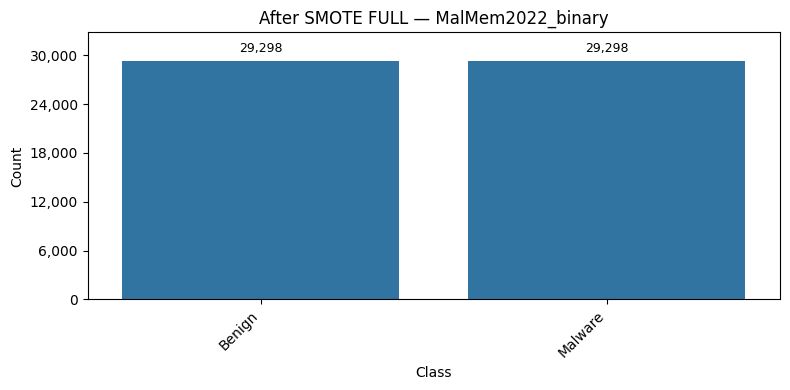

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_after_only_smote_FULL_MalMem2022_binary.png
🖼 AFTER SMOTE FULL FIG --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_after_only_smote_FULL_MalMem2022_binary.png
✂️ Split (FULL-SMOTE): X_train=(46876, 55), X_test=(11720, 55), y_train=46876, y_test=11720


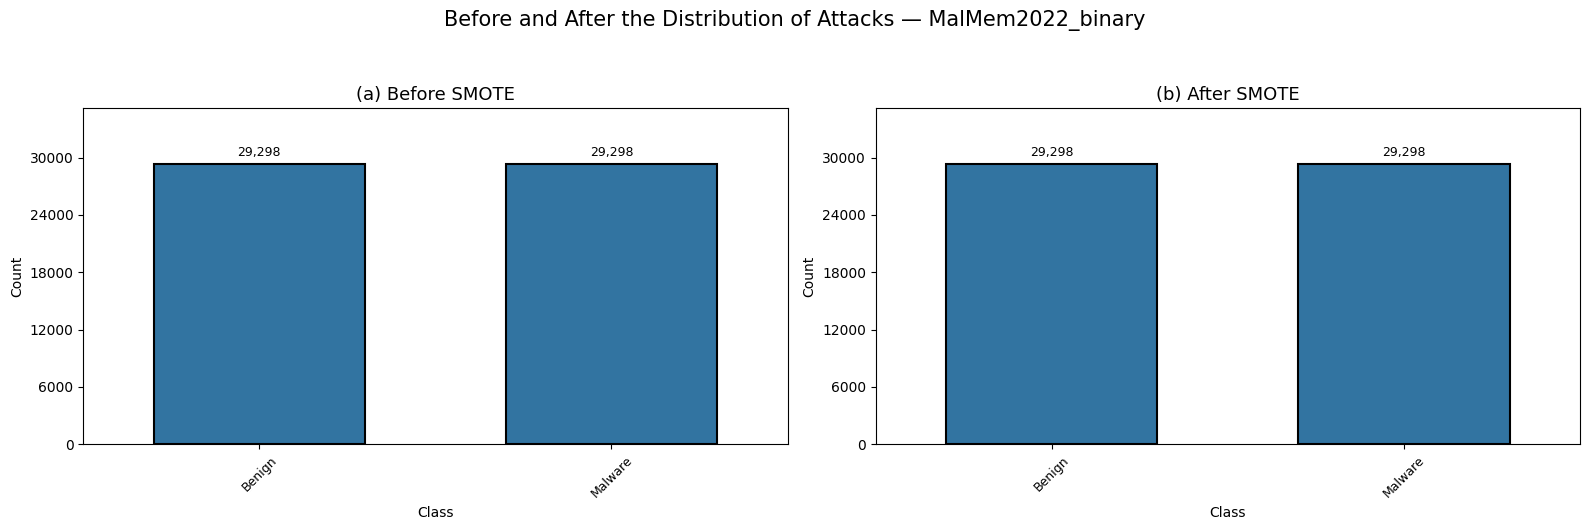

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_before_after_smote_MalMem2022_binary.png


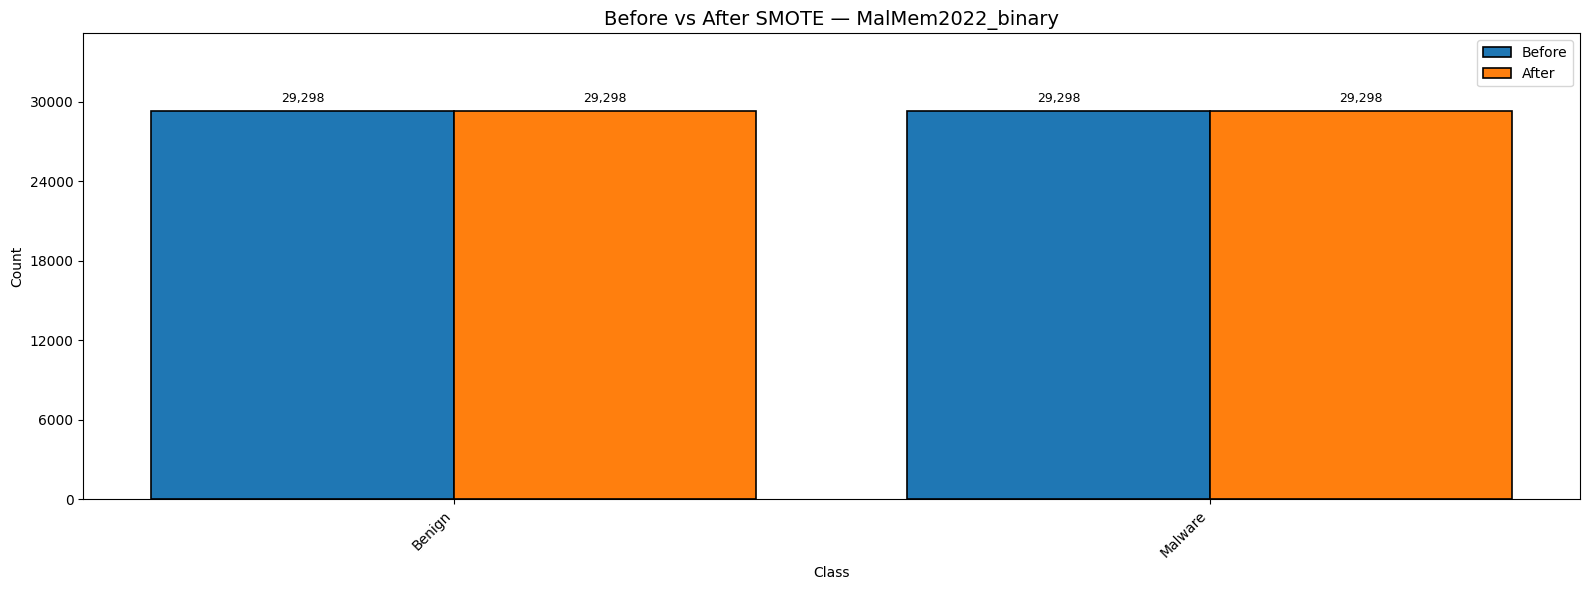

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_before_vs_after_smote_MalMem2022_binary.png
🖼 BEFORE vs AFTER FIG --> /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/class_dist_before_vs_after_smote_MalMem2022_binary.png
✅ Bloque 6 completado (v6.1). X_train=(46876, 55), X_test=(11720, 55), y_train=46876, y_test=11720, SMOTE_MODE=full.
✅ BLOQUE 6 OK — modo: full
⏱ Fin bloque 6 - Train/Test split, escalado y SMOTE (v6.1) (duración: 1.47 s)


In [36]:
## ============================================================
## 6) Train/Test split, escalado y SMOTE (full / dynamic / none) — v6.1
## ============================================================

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from matplotlib.ticker import MaxNLocator, StrMethodFormatter

with timed_block("6 - Train/Test split, escalado y SMOTE (v6.1)"):

    # ----------------------------------------------------------
    # 0) Validaciones previas
    # ----------------------------------------------------------
    if 'X' not in locals() or 'y' not in locals():
        raise ValueError("❌ No existen X e y. Ejecuta el BLOQUE 5 antes de este.")

    if 'class_names' not in locals():
        raise ValueError(
            "❌ 'class_names' no existe. Asegúrate de haber ejecutado el BLOQUE 5 "
            "actualizado, donde se define class_names."
        )

    if 'SMOTE_MODE' not in globals():
        SMOTE_MODE = "dynamic"

    if SMOTE_MODE not in ("full", "dynamic", "none"):
        raise ValueError(
            f"❌ SMOTE_MODE='{SMOTE_MODE}' no es válido. Usa 'full', 'dynamic' o 'none'."
        )

    _append_log(
        f"🔎 Bloque 6 (v6.1): X={X.shape}, y={len(y)}, n_classes={len(class_names)}, "
        f"SMOTE_MODE={SMOTE_MODE}"
    )
    print("🪪 class_names usados en Bloque 6:", class_names)

    # Helper: índice → nombre de clase
    def _index_to_label(idx):
        try:
            idx_int = int(idx)
            if 0 <= idx_int < len(class_names):
                return str(class_names[idx_int])
        except Exception:
            pass
        return str(idx)

    # Variables globales que usaremos en otros bloques
    global X_train, X_test, y_train, y_test, X_for_fs, y_for_fs, scaler

    # ----------------------------------------------------------
    # ╔══════════════════════╗
    # ║  MODO 1: SMOTE FULL  ║  (estilo paper)
    # ╚══════════════════════╝
    # ----------------------------------------------------------
    if SMOTE_MODE == "full":
        _append_log("🧬 Modo SMOTE_FULL: SMOTE al dataset completo (estilo paper).")

        # 1) Limpieza global
        X_df = pd.DataFrame(X).replace([np.inf, -np.inf], np.nan).fillna(0)

        # 2) Escalado global
        scaler = StandardScaler(with_mean=False)
        X_scaled = scaler.fit_transform(X_df)
        _append_log("📏 Escalado global con StandardScaler(with_mean=False).")

        # 3) Distribución BEFORE (dataset completo)
        y_series = pd.Series(y)
        counts_before = y_series.value_counts().sort_index()
        idxs = counts_before.index.tolist()
        labels = [_index_to_label(i) for i in idxs]
        counts_before_aligned = counts_before.reindex(idxs).astype(int)

        before_full_df = pd.DataFrame({
            "Class": labels,
            "Count Before": counts_before_aligned.values
        })

        before_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_only_FULL.csv")
        save_and_display_table(
            before_full_df, before_csv,
            note="Before SMOTE (dataset completo, modo FULL)."
        )
        _append_log(f"📄 BEFORE SMOTE (FULL) CSV --> {before_csv}")

        # 4) SMOTE FULL: igualar todas las clases al máx. conteo
        max_count = counts_before.max()
        sampling_strategy = {
            cls_idx: max_count
            for cls_idx, cnt in counts_before.items()
            if cnt < max_count
        }

        if not sampling_strategy:
            _append_log("ℹ️ Todas las clases ya están balanceadas. No se aplica SMOTE FULL.")
            X_bal = X_scaled
            y_bal = y.copy()
        else:
            min_count = counts_before.min()
            k_neighbors = max(1, min(5, min_count - 1))
            _append_log(
                f"🧪 SMOTE FULL sampling_strategy={sampling_strategy}, "
                f"k={k_neighbors}, max_count={max_count}"
            )
            sm = SMOTE(
                random_state=42,
                sampling_strategy=sampling_strategy,
                k_neighbors=k_neighbors,
                n_jobs=-1
            )
            X_bal, y_bal = sm.fit_resample(X_scaled, y)

        # 5) Distribución AFTER (dataset completo balanceado)
        counts_after = pd.Series(y_bal).value_counts().sort_index()
        counts_after = counts_after.reindex(idxs).fillna(0).astype(int)

        comp_full_df = pd.DataFrame({
            "Class": labels,
            "Count_Before": counts_before_aligned.values,
            "Count_After": counts_after.values,
            "Diff": counts_after.values - counts_before_aligned.values
        })

        comp_csv = os.path.join(
            REP_DIR,
            f"{RUN_TAG}_class_dist_before_after_smote_FULL.csv"
        )
        save_and_display_table(
            comp_full_df, comp_csv,
            note="Before & After SMOTE FULL (dataset completo)."
        )
        _append_log(f"📄 BEFORE/AFTER (FULL) CSV --> {comp_csv}")

        # --- Para los gráficos comunes (8 y 9) ---
        dist_wide = comp_full_df.copy()
        n_classes_plot = len(dist_wide["Class"])

        # --- Gráfico SOLO AFTER (FULL) ---
        plt.figure(figsize=(8, 4))
        ax_after = sns.barplot(x="Class", y="Count_After", data=dist_wide)
        max_after = 0
        for p in ax_after.patches:
            h = p.get_height()
            max_after = max(max_after, h)
            if h > 0:
                ax_after.annotate(
                    f"{int(h):,}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom',
                    fontsize=9,
                    xytext=(0, 4),
                    textcoords='offset points'
                )
        ax_after.set_title(f"After SMOTE FULL — {RUN_TAG}")
        ax_after.set_xlabel("Class")
        ax_after.set_ylabel("Count")
        ax_after.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax_after.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        ax_after.set_ylim(top=max_after * 1.12 if max_after > 0 else 1)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()

        fig_path_after_full = os.path.join(
            FIG_DIR,
            f"class_dist_after_only_smote_FULL_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_after_full)
        _append_log(f"🖼 AFTER SMOTE FULL FIG --> {fig_path_after_full}")

        # 6) Split sobre el dataset ya balanceado (estilo paper)
        strat_arg = y_bal if len(set(y_bal)) > 1 else None
        X_train, X_test, y_train, y_test = train_test_split(
            X_bal, y_bal,
            test_size=0.2,
            random_state=42,
            stratify=strat_arg
        )

        # Para Feature Selection (Bloque 7) usamos el train balanceado
        X_for_fs = X_train
        y_for_fs = y_train

        _append_log(
            f"✂️ Split (FULL-SMOTE): X_train={X_train.shape}, X_test={X_test.shape}, "
            f"y_train={len(y_train)}, y_test={len(y_test)}"
        )

    # ----------------------------------------------------------
    # ╔════════════════════════════════════╗
    # ║  MODO 2/3: SMOTE DINÁMICO / NONE  ║
    # ╚════════════════════════════════════╝
    # ----------------------------------------------------------
    else:
        # 1) Split previo (sin SMOTE)
        strat_arg = y if len(set(y)) > 1 else None
        X_train_raw, X_test_raw, y_train_raw, y_test = train_test_split(
            X, y,
            test_size=0.2,
            random_state=42,
            stratify=strat_arg
        )
        _append_log(
            f"✂️ Split: X_train={X_train_raw.shape}, X_test={X_test_raw.shape}, "
            f"y_train={len(y_train_raw)}, y_test={len(y_test)}"
        )

        # 2) Limpieza de inf / NaN → 0
        X_train_df = pd.DataFrame(X_train_raw).replace([np.inf, -np.inf], np.nan).fillna(0)
        X_test_df  = pd.DataFrame(X_test_raw).replace([np.inf, -np.inf], np.nan).fillna(0)
        _append_log("🧹 Limpieza completada (inf → NaN → 0).")

        # 3) Escalado
        scaler = StandardScaler(with_mean=False)
        X_train_scaled = scaler.fit_transform(X_train_df)
        X_test_scaled  = scaler.transform(X_test_df)
        _append_log("📏 Escalado con StandardScaler(with_mean=False).")

        # 4) Distribución BEFORE (train)
        y_train_series = pd.Series(y_train_raw)
        counts_before = y_train_series.value_counts().sort_index()
        class_indices_sorted = counts_before.index.tolist()
        labels_sorted = [_index_to_label(c) for c in class_indices_sorted]
        counts_before_aligned = counts_before.reindex(class_indices_sorted).astype(int)

        print("🔤 Mapeo índice→Clase en Bloque 6 (train):")
        for idx, name in zip(class_indices_sorted, labels_sorted):
            print(f"  {idx} → {name}")

        before_df = pd.DataFrame({
            "Class": labels_sorted,
            "Count Before": counts_before_aligned.values
        })

        before_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_only.csv")
        save_and_display_table(
            before_df, before_csv,
            note="Before SMOTE (train set)."
        )
        _append_log(f"📄 BEFORE SMOTE CSV --> {before_csv}")

        # 5) Según SMOTE_MODE → aplicar o no SMOTE DINÁMICO
        n_classes = len(counts_before)
        min_count = counts_before.min()
        apply_smote = (
            SMOTE_MODE == "dynamic" and
            n_classes > 1 and
            min_count >= 2
        )

        if not apply_smote:
            if SMOTE_MODE == "none":
                _append_log("🚫 Modo NONE: no se aplica SMOTE. Usando train escalado tal cual.")
            else:
                _append_log("⚠️ SMOTE omitido (clases/muestras insuficientes).")
            X_train = X_train_scaled
            y_train = y_train_raw.copy()
            X_test = X_test_scaled
            counts_after = counts_before_aligned.copy()
        else:
            median_count = counts_before.median()
            max_count = counts_before.max()
            base_target = int(min(
                max_count,
                max(5000, int(median_count * 1.5))
            ))
            upper_cap = int(min(max_count, base_target * 3))

            _append_log(
                f"🔧 SMOTE Inteligente: min={min_count}, med={median_count}, max={max_count}, "
                f"base_target={base_target}, upper_cap={upper_cap}"
            )

            sampling_strategy = {}
            for cls_idx, cnt in counts_before.items():
                if cnt < base_target:
                    sampling_strategy[cls_idx] = int(min(base_target, upper_cap))

            if not sampling_strategy:
                _append_log("ℹ️ No hay clases minoritarias. No se aplica SMOTE.")
                X_train = X_train_scaled
                y_train = y_train_raw.copy()
                X_test = X_test_scaled
                counts_after = counts_before_aligned.copy()
            else:
                eligible = [
                    cnt for cls_idx, cnt in counts_before.items()
                    if cls_idx in sampling_strategy and cnt > 1
                ]
                min_for_knn = min(eligible) if eligible else 2
                k_neighbors = max(1, min(5, min_for_knn - 1))

                _append_log(f"🧪 SMOTE sampling_strategy={sampling_strategy}, k={k_neighbors}")

                sm = SMOTE(
                    random_state=42,
                    sampling_strategy=sampling_strategy,
                    k_neighbors=k_neighbors,
                    n_jobs=-1
                )
                X_train_res, y_train_res = sm.fit_resample(X_train_scaled, y_train_raw)

                X_train = X_train_res
                y_train = y_train_res
                X_test = X_test_scaled

                counts_after_series = pd.Series(y_train).value_counts().sort_index()
                counts_after = counts_after_series.reindex(class_indices_sorted).fillna(0).astype(int)

        # Para Feature Selection (Bloque 7): usamos SIEMPRE el train resultante
        X_for_fs = X_train
        y_for_fs = y_train

        # Tabla BEFORE/AFTER/DIFF (train)
        comp_df = pd.DataFrame({
            "Class": labels_sorted,
            "Count_Before": counts_before_aligned.values,
            "Count_After": counts_after.values,
            "Diff": counts_after.values - counts_before_aligned.values
        })

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_class_dist_before_after_smote.csv")
        save_and_display_table(
            comp_df,
            comp_csv,
            note="Before & After SMOTE (train set, class names)."
        )
        _append_log(f"📄 BEFORE/AFTER CSV --> {comp_csv}")

        dist_wide = comp_df.copy()
        n_classes_plot = len(dist_wide["Class"])

        # --- Gráfico SOLO AFTER (train) ---
        label_font_after = 9 if n_classes_plot <= 10 else 7

        plt.figure(figsize=(8, 4))
        ax_after = sns.barplot(x='Class', y='Count_After', data=dist_wide)
        max_after = 0
        for p in ax_after.patches:
            h = p.get_height()
            max_after = max(max_after, h)
            if h > 0:
                ax_after.annotate(
                    f"{int(h):,}",
                    (p.get_x() + p.get_width()/2., h),
                    ha='center', va='bottom',
                    fontsize=label_font_after,
                    xytext=(0, 4),
                    textcoords='offset points'
                )
        ax_after.set_title(f"After SMOTE ({SMOTE_MODE}) — {RUN_TAG}", fontsize=13)
        ax_after.set_xlabel("Class")
        ax_after.set_ylabel("Count")
        ax_after.yaxis.set_major_locator(MaxNLocator(nbins=6, integer=True))
        ax_after.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
        ax_after.set_ylim(top=max_after * 1.12 if max_after > 0 else 1)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        fig_path_after_only = os.path.join(
            FIG_DIR,
            f"class_dist_after_only_smote_{SMOTE_MODE}_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_after_only)
        _append_log(f"🖼 AFTER SMOTE ({SMOTE_MODE}) FIG --> {fig_path_after_only}")

    # ==================================================================
    # 8) Gráfico Before & After (subplots a/b) — usa dist_wide común
    # ==================================================================
    plt.figure(figsize=(16, 5))
    label_font_sub = 9 if n_classes_plot <= 10 else 7

    # (a) BEFORE
    ax1 = plt.subplot(1, 2, 1)
    sns.barplot(
        x='Class', y='Count_Before', data=dist_wide,
        ax=ax1,
        linewidth=1.5,
        edgecolor='black',
        width=0.6
    )

    max_b1 = 0
    for p in ax1.patches:
        h = p.get_height()
        max_b1 = max(max_b1, h)
        if h > 0:
            ax1.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width()/2., h),
                ha='center', va='bottom',
                fontsize=label_font_sub,
                xytext=(0, 4),
                textcoords='offset points'
            )

    ax1.set_title("(a) Before SMOTE", fontsize=13)
    ax1.set_xlabel("Class")
    ax1.set_ylabel("Count")
    ax1.get_yaxis().get_major_formatter().set_scientific(False)
    ax1.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
    ax1.set_ylim(top=max_b1 * 1.20)
    ax1.tick_params(axis='x', rotation=45, labelsize=9)

    # (b) AFTER
    ax2 = plt.subplot(1, 2, 2)
    sns.barplot(
        x='Class', y='Count_After', data=dist_wide,
        ax=ax2,
        linewidth=1.5,
        edgecolor='black',
        width=0.6
    )

    max_b2 = 0
    for p in ax2.patches:
        h = p.get_height()
        max_b2 = max(max_b2, h)
        if h > 0:
            ax2.annotate(
                f"{int(h):,}",
                (p.get_x() + p.get_width()/2., h),
                ha='center', va='bottom',
                fontsize=label_font_sub,
                xytext=(0, 4),
                textcoords='offset points'
            )

    ax2.set_title("(b) After SMOTE", fontsize=13)
    ax2.set_xlabel("Class")
    ax2.set_ylabel("Count")
    ax2.get_yaxis().get_major_formatter().set_scientific(False)
    ax2.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
    ax2.set_ylim(top=max_b2 * 1.20)
    ax2.tick_params(axis='x', rotation=45, labelsize=9)

    plt.suptitle(f"Before and After the Distribution of Attacks — {RUN_TAG}",
                 fontsize=15, y=1.05)
    plt.tight_layout()

    fig_path_before_after = os.path.join(
        FIG_DIR,
        f"class_dist_before_after_smote_{RUN_TAG}.png"
    )
    show_and_save_current_fig(fig_path_before_after)

    # ==================================================================
    # 9) Barras dobles (Before vs After en un solo gráfico)
    # ==================================================================
    if dist_wide.empty:
        print("⚠️ dist_wide está vacío, no se genera gráfico 9.")
    else:
        dist_wide_plot = dist_wide.copy()
        dist_wide_plot["Class"] = dist_wide_plot["Class"].astype(str)

        fig, ax = plt.subplots(figsize=(16, 6))
        x = np.arange(len(dist_wide_plot["Class"]))
        width = 0.4

        bars_before = ax.bar(
            x - width/2,
            dist_wide_plot["Count_Before"],
            width,
            label="Before",
            edgecolor="black",
            linewidth=1.2
        )
        bars_after = ax.bar(
            x + width/2,
            dist_wide_plot["Count_After"],
            width,
            label="After",
            edgecolor="black",
            linewidth=1.2
        )

        max_combo = max(
            dist_wide_plot["Count_Before"].max(),
            dist_wide_plot["Count_After"].max()
        )

        label_font_both = 9 if n_classes_plot <= 10 else 7

        if n_classes_plot <= 10:
            for rect in bars_before:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )
            for rect in bars_after:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )
        else:
            for rect in bars_after:
                h = rect.get_height()
                if h > 0:
                    ax.annotate(
                        f"{int(h):,}",
                        xy=(rect.get_x() + rect.get_width()/2, h),
                        xytext=(0, 4),
                        textcoords="offset points",
                        ha="center",
                        va="bottom",
                        fontsize=label_font_both
                    )

        ax.set_xticks(x)
        ax.set_xticklabels(dist_wide_plot["Class"], rotation=45, ha="right")
        ax.set_ylabel("Count")
        ax.set_xlabel("Class")
        ax.set_title(f"Before vs After SMOTE — {RUN_TAG}", fontsize=14)
        ax.get_yaxis().get_major_formatter().set_scientific(False)
        ax.yaxis.set_major_locator(MaxNLocator(nbins=7, integer=True))
        ax.set_ylim(top=max_combo * 1.20 if max_combo > 0 else 1)
        ax.legend()
        fig.tight_layout()

        fig_path_both = os.path.join(
            FIG_DIR,
            f"class_dist_before_vs_after_smote_{RUN_TAG}.png"
        )
        show_and_save_current_fig(fig_path_both)
        _append_log(f"🖼 BEFORE vs AFTER FIG --> {fig_path_both}")

    # ----------------------------------------------------------
    # FIN
    # ----------------------------------------------------------
    _append_log(
        f"✅ Bloque 6 completado (v6.1). X_train={X_for_fs.shape}, "
        f"X_test={X_test.shape}, y_train={len(y_for_fs)}, y_test={len(y_test)}, "
        f"SMOTE_MODE={SMOTE_MODE}."
    )
    print("✅ BLOQUE 6 OK — modo:", SMOTE_MODE)


## 7) **XGBoost**: importancia de características + selección **Top‑k**

📌 FS: usando X_for_fs / y_for_fs (Bloque 6, respeta SMOTE_MODE).
▶️ Inicio bloque 7 - XGBoost Feature Importance + selección Top-N
🔍 Total de features numéricas: 55
♻️ Cargando checkpoint previo de XGBoost + lista de features…
👉 Top-20 features restauradas: ['svcscan.shared_process_services', 'svcscan.nservices', 'svcscan.process_services', 'handles.avg_handles_per_proc', 'callbacks.ncallbacks', 'handles.ndesktop', 'psxview.not_in_deskthrd', 'ldrmodules.not_in_load_avg', 'ldrmodules.not_in_mem_avg', 'handles.nevent', 'psxview.not_in_ethread_pool_false_avg', 'psxview.not_in_pslist', 'malfind.commitCharge', 'psxview.not_in_ethread_pool', 'pslist.avg_handlers', 'psxview.not_in_session_false_avg', 'psxview.not_in_pslist_false_avg', 'malfind.ninjections', 'handles.nfile', 'psxview.not_in_deskthrd_false_avg']


,feature,importance,rank
0,svcscan.shared_process_services,0.574770,1
1,svcscan.nservices,0.406505,2
2,svcscan.process_services,0.005038,3
3,handles.avg_handles_per_proc,0.001764,4
4,callbacks.ncallbacks,0.001275,5
5,handles.ndesktop,0.001118,6
6,psxview.not_in_deskthrd,0.001043,7
7,ldrmodules.not_in_load_avg,0.000768,8
8,ldrmodules.not_in_mem_avg,0.000683,9
9,handles.nevent,0.000479,10


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_feature_importance_full.csv — Full ranking (checkpoint)


,feature,importance,rank
0,svcscan.shared_process_services,0.574770,1
1,svcscan.nservices,0.406505,2
2,svcscan.process_services,0.005038,3
3,handles.avg_handles_per_proc,0.001764,4
4,callbacks.ncallbacks,0.001275,5
5,handles.ndesktop,0.001118,6
6,psxview.not_in_deskthrd,0.001043,7
7,ldrmodules.not_in_load_avg,0.000768,8
8,ldrmodules.not_in_mem_avg,0.000683,9
9,handles.nevent,0.000479,10


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_feature_importance_top20.csv — Top-N (checkpoint)


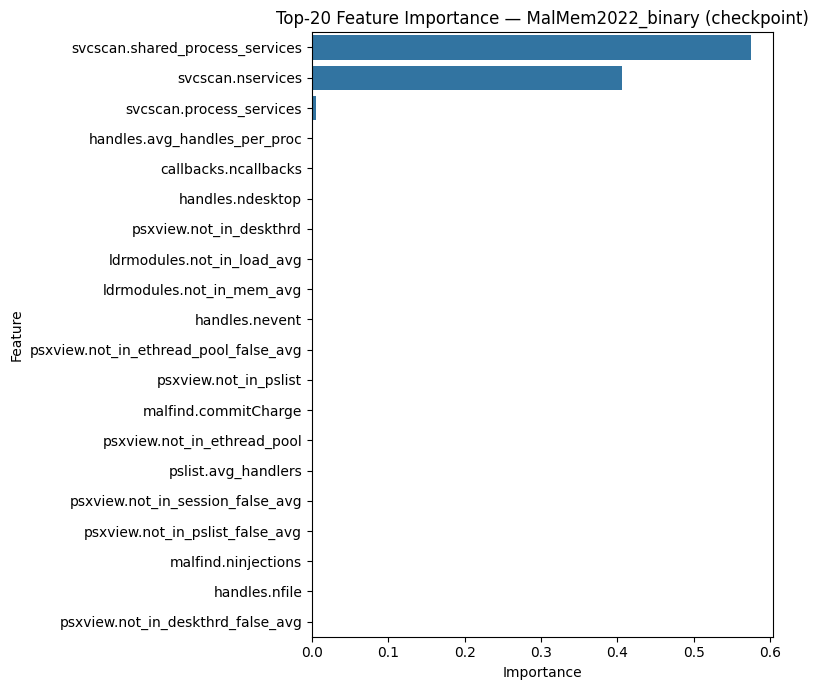

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_feature_importance_top20.png
✅ Bloque 7 completado (modo LOAD).
⏱ Fin bloque 7 - XGBoost Feature Importance + selección Top-N (duración: 0.80 s)


In [37]:
## ============================================================
## 7) XGBoost Feature Importance + Selección de Top-N Features — v6.1
## ============================================================

from xgboost import XGBClassifier
import os, json

# 1) Elegir la fuente correcta (salida del Bloque 6)
if 'X_for_fs' in locals() and 'y_for_fs' in locals():
    X_fs = X_for_fs
    y_fs = y_for_fs
    _append_log("📌 FS: usando X_for_fs / y_for_fs (Bloque 6, respeta SMOTE_MODE).")
else:
    X_fs = X_train
    y_fs = y_train
    _append_log("📌 FS: usando X_train / y_train (fallback).")

TOP_N_FEATURES = 20  # Ajustable

with timed_block("7 - XGBoost Feature Importance + selección Top-N"):

    # ----------------------------
    # Validaciones
    # ----------------------------
    if 'X_train' not in locals() or 'y_train' not in locals():
        raise ValueError("❌ Ejecuta Bloques 5 y 6 antes del Bloque 7.")

    # ----------------------------
    # Obtener nombres de features
    # ----------------------------
    if hasattr(X, "columns"):
        feature_names = list(X.columns)
    else:
        feature_names = [f"f{i}" for i in range(X.shape[1])]

    n_features = len(feature_names)
    _append_log(f"🔍 Total de features numéricas: {n_features}")

    # ----------------------------
    # Rutas
    # ----------------------------
    xgb_model_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_xgb_base.json")
    feat_meta_path = os.path.join(REP_DIR, f"{RUN_TAG}_selected_features.json")

    did_load = False

    # ============================================================
    # 1) LOAD MODE — si existe checkpoint
    # ============================================================
    if os.path.exists(xgb_model_path) and os.path.exists(feat_meta_path):
        did_load = True
        _append_log("♻️ Cargando checkpoint previo de XGBoost + lista de features…")

        xgb_clf = XGBClassifier()
        xgb_clf.load_model(xgb_model_path)

        # cargar metadata
        with open(feat_meta_path, "r") as f:
            meta = json.load(f)

        selected_features = meta["selected_features"]
        top_n = meta["top_n"]

        # mapa para índices
        feature_to_idx = {name: i for i, name in enumerate(feature_names)}
        selected_idx = [feature_to_idx[f] for f in selected_features]

        # reconstruir matrices seleccionadas
        X_train_sel = X_train[:, selected_idx]
        X_test_sel  = X_test[:, selected_idx]

        _append_log(f"👉 Top-{top_n} features restauradas: {selected_features}")

        # Importancias completas desde el modelo cargado
        importances = xgb_clf.feature_importances_

        imp_df = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            })
            .sort_values("importance", ascending=False)
            .reset_index(drop=True)
        )
        imp_df["rank"] = imp_df.index + 1

        # Guardar tabla full
        full_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_full.csv")
        save_and_display_table(imp_df, full_csv, note="Full ranking (checkpoint)")

        # Top-N
        imp_top = imp_df[imp_df["feature"].isin(selected_features)]
        top_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.csv")
        save_and_display_table(imp_top, top_csv, note="Top-N (checkpoint)")

        # gráfico
        plt.figure(figsize=(8, max(4, top_n * 0.35)))
        sns.barplot(
            x="importance", y="feature",
            data=imp_top.sort_values("importance", ascending=False),
            orient="h"
        )
        plt.title(f"Top-{top_n} Feature Importance — {RUN_TAG} (checkpoint)")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        fig_path_imp = os.path.join(FIG_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.png")
        show_and_save_current_fig(fig_path_imp)

        _append_log("✅ Bloque 7 completado (modo LOAD).")

    # ============================================================
    # 2) TRAIN MODE — si no existe checkpoint previo
    # ============================================================
    if not did_load:
        _append_log("🚀 No hay checkpoint. Entrenando XGBoost para selección de features…")

        # parámetros
        xgb_params = {
            "n_estimators": 200,
            "max_depth": 6,
            "learning_rate": 0.1,
            "subsample": 0.8,
            "colsample_bytree": 0.8,
            "objective": "multi:softprob" if len(np.unique(y_fs)) > 2 else "binary:logistic",
            "tree_method": "hist",
            "n_jobs": -1,
            "eval_metric": "mlogloss" if len(np.unique(y_fs)) > 2 else "logloss",
            "random_state": 42,
        }

        t0 = time.time()
        xgb_clf = XGBClassifier(**xgb_params)
        xgb_clf.fit(X_fs, y_fs)
        t_train_xgb = time.time() - t0
        _append_log(f"⏱ XGBoost entrenado en {t_train_xgb:.2f} s.")

        # Importancias
        importances = xgb_clf.feature_importances_

        imp_df = (
            pd.DataFrame({
                "feature": feature_names,
                "importance": importances
            })
            .sort_values(by="importance", ascending=False)
            .reset_index(drop=True)
        )
        imp_df["rank"] = imp_df.index + 1

        # Tabla full
        full_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_full.csv")
        save_and_display_table(imp_df, full_csv, note="Full ranking (trained)")

        # top-n
        top_n = min(TOP_N_FEATURES, n_features)
        imp_top = imp_df.head(top_n).copy()

        top_csv = os.path.join(REP_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.csv")
        save_and_display_table(imp_top, top_csv, note=f"Top-{top_n} features (trained)")

        # gráfico
        plt.figure(figsize=(8, max(4, top_n * 0.35)))
        sns.barplot(
            x="importance",
            y="feature",
            data=imp_top,
            orient="h"
        )
        plt.title(f"Top-{top_n} Feature Importance — {RUN_TAG}")
        plt.xlabel("Importance")
        plt.ylabel("Feature")
        fig_path_imp = os.path.join(FIG_DIR, f"{RUN_TAG}_feature_importance_top{top_n}.png")
        show_and_save_current_fig(fig_path_imp)

        # Seleccionar features
        selected_features = imp_top["feature"].tolist()
        feature_to_idx = {name: i for i, name in enumerate(feature_names)}
        selected_idx = [feature_to_idx[f] for f in selected_features]

        X_train_sel = X_train[:, selected_idx]
        X_test_sel  = X_test[:, selected_idx]

        _append_log(
            f"✨ Top-{top_n} features seleccionadas. "
            f"X_train_sel={X_train_sel.shape}, X_test_sel={X_test_sel.shape}"
        )

        # Guardar metadata
        meta = {
            "run_tag": RUN_TAG,
            "top_n": top_n,
            "selected_features": selected_features,
            "train_time_xgb_s": t_train_xgb
        }
        save_json(meta, feat_meta_path)

        # Guardar modelo
        xgb_clf.save_model(xgb_model_path)
        record_model(f"{RUN_TAG}_xgb_base", xgb_model_path)
        _append_log(f"💾 Modelo XGBoost almacenado en: {xgb_model_path}")

        log_result({
            "block": "7_feature_importance",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "top_n": top_n,
            "selected_features": selected_features,
            "train_time_xgb_s": t_train_xgb,
        })

        _append_log("✅ Bloque 7 completado (ENTRENAMIENTO).")


## 8) ML: entrenamiento con **checkpoints**, CMs y ROC

▶️ Inicio bloque 8 - Entrenamiento y evaluación de modelos ML (con checkpoint)
📌 ML: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).
🔢 ML: n_classes=2 (is_binary=True), SMOTE_MODE=full.
🔹 ML: iniciando modelo RF…
♻️ RF: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_RF_ML.pkl (no se reentrena).
⏱ RF: train_time_s original=2.44s, smote_mode_guardado=full.
⏩ RF: usando modelo ya entrenado (train_time_s=2.44s).
✅ RF: Acc=99.99%, Prec=99.99%, Rec=99.99%, F1=99.99%, MAE=0.000085, MSE=0.000085, RMSE=0.009237, AUC=100.00%, Train=2.44s, Pred=0.08s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5859,1
1,Malware,0,5860


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_RF.csv — Confusion matrix for RF


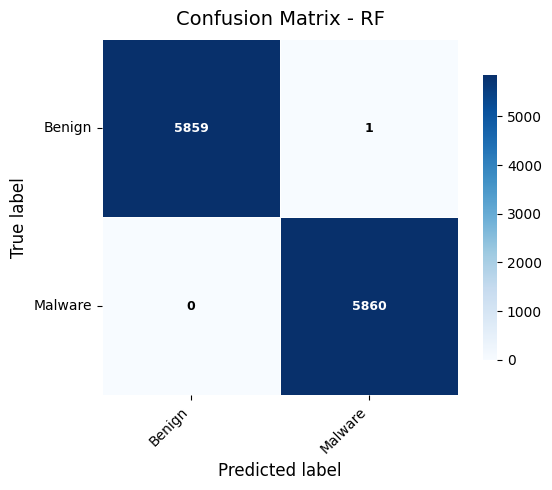

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_RF.png
🖼 Matriz de confusión de RF guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_RF.png
🔹 ML: iniciando modelo DT…
♻️ DT: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_DT_ML.pkl (no se reentrena).
⏱ DT: train_time_s original=0.24s, smote_mode_guardado=full.
⏩ DT: usando modelo ya entrenado (train_time_s=0.24s).
✅ DT: Acc=99.97%, Prec=99.97%, Rec=99.97%, F1=99.97%, MAE=0.000256, MSE=0.000256, RMSE=0.015999, AUC=99.97%, Train=0.24s, Pred=0.00s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5858,2
1,Malware,1,5859


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_DT.csv — Confusion matrix for DT


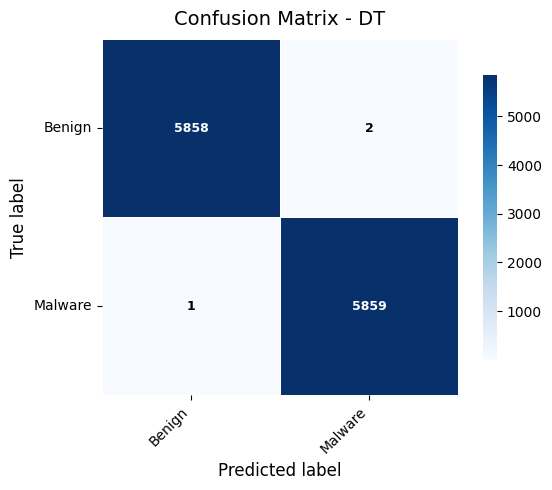

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_DT.png
🖼 Matriz de confusión de DT guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_DT.png
🔹 ML: iniciando modelo KNN…
♻️ KNN: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_KNN_ML.pkl (no se reentrena).
⏱ KNN: train_time_s original=0.01s, smote_mode_guardado=full.
⏩ KNN: usando modelo ya entrenado (train_time_s=0.01s).
✅ KNN: Acc=99.94%, Prec=99.94%, Rec=99.94%, F1=99.94%, MAE=0.000597, MSE=0.000597, RMSE=0.024439, AUC=100.00%, Train=0.01s, Pred=0.90s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5855,5
1,Malware,2,5858


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_KNN.csv — Confusion matrix for KNN


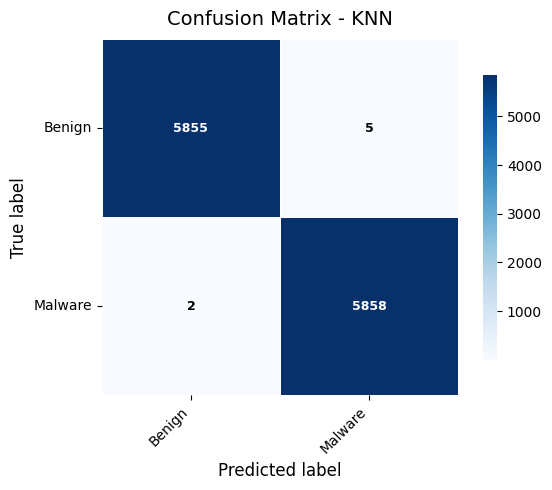

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_KNN.png
🖼 Matriz de confusión de KNN guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_KNN.png
🔹 ML: iniciando modelo MLP…
♻️ MLP: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_MLP_ML.pkl (no se reentrena).
⏱ MLP: train_time_s original=20.03s, smote_mode_guardado=full.
⏩ MLP: usando modelo ya entrenado (train_time_s=20.03s).
✅ MLP: Acc=99.82%, Prec=99.82%, Rec=99.82%, F1=99.82%, MAE=0.001792, MSE=0.001792, RMSE=0.042330, AUC=99.99%, Train=20.03s, Pred=0.01s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5852,8
1,Malware,13,5847


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_MLP.csv — Confusion matrix for MLP


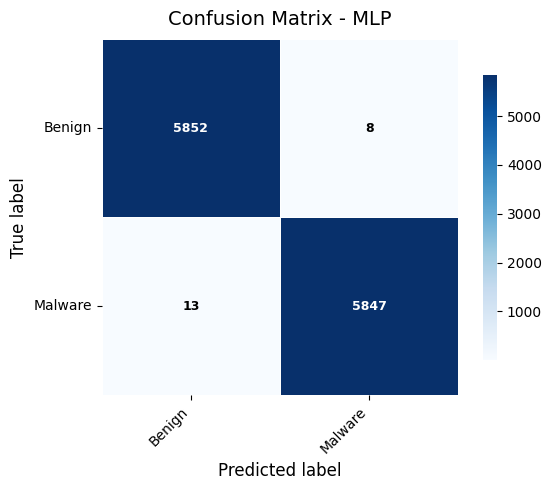

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_MLP.png
🖼 Matriz de confusión de MLP guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_MLP.png
🔹 ML: iniciando modelo LIGHTGBM…
♻️ LIGHTGBM: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_LIGHTGBM_ML.pkl (no se reentrena).
⏱ LIGHTGBM: train_time_s original=1.11s, smote_mode_guardado=full.
⏩ LIGHTGBM: usando modelo ya entrenado (train_time_s=1.11s).
✅ LIGHTGBM: Acc=100.00%, Prec=100.00%, Rec=100.00%, F1=100.00%, MAE=0.000000, MSE=0.000000, RMSE=0.000000, AUC=100.00%, Train=1.11s, Pred=0.03s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5860,0
1,Malware,0,5860


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_LIGHTGBM.csv — Confusion matrix for LIGHTGBM


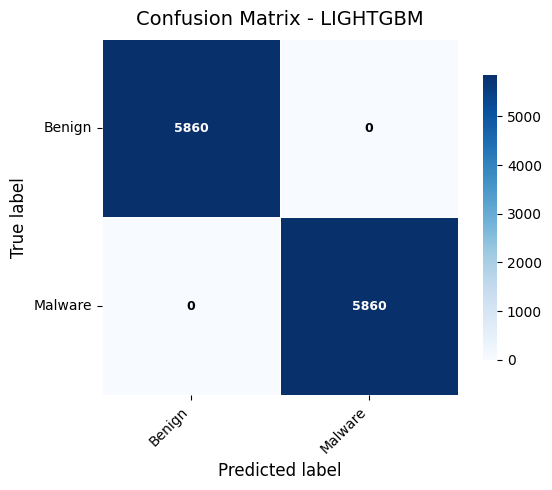

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_LIGHTGBM.png
🖼 Matriz de confusión de LIGHTGBM guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_LIGHTGBM.png
🔹 ML: iniciando modelo CATBOOST…
♻️ CATBOOST: checkpoint cargado desde /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_CATBOOST_ML.pkl (no se reentrena).
⏱ CATBOOST: train_time_s original=1.79s, smote_mode_guardado=full.
⏩ CATBOOST: usando modelo ya entrenado (train_time_s=1.79s).
✅ CATBOOST: Acc=100.00%, Prec=100.00%, Rec=100.00%, F1=100.00%, MAE=0.000000, MSE=0.000000, RMSE=0.000000, AUC=100.00%, Train=1.79s, Pred=0.01s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5860,0
1,Malware,0,5860


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_CATBOOST.csv — Confusion matrix for CATBOOST


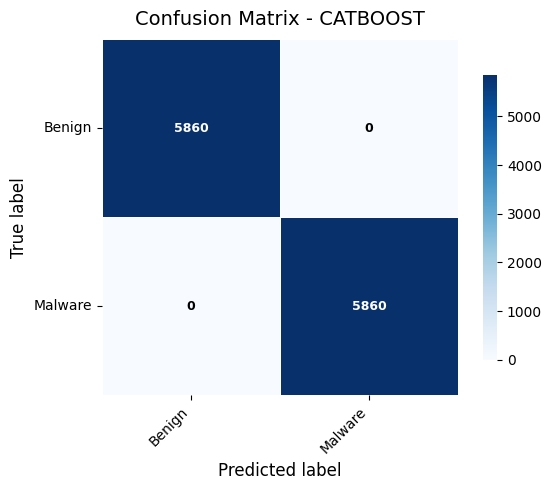

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_CATBOOST.png
🖼 Matriz de confusión de CATBOOST guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_CATBOOST.png
✅ Bloque 8 completado (ML: entrenamiento/carga, métricas y matrices de confusión).
⏱ Fin bloque 8 - Entrenamiento y evaluación de modelos ML (con checkpoint) (duración: 5.17 s)


In [38]:
## ============================================================
## 8) Modelos ML (RF, DT, KNN, MLP, LightGBM, CatBoost) + checkpoint — v6.1
##     - Usa X_train_sel / X_test_sel si existen (Top-N por XGBoost)
##     - Métricas en porcentaje (Acc, Prec, Rec, F1, AUC)
##     - MAE/MSE/RMSE en escala normal
##     - Compatible con SMOTE_MODE (full / dynamic / none)
## ============================================================

import os, time, json, joblib
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

with timed_block("8 - Entrenamiento y evaluación de modelos ML (con checkpoint)"):

    # ------------------------------------------------------
    # 0) Selección de X_train / X_test (Top-N o todas)
    # ------------------------------------------------------
    if 'X_train_sel' in locals() and 'X_test_sel' in locals():
        Xtr, Xte = X_train_sel, X_test_sel
        _append_log("📌 ML: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).")
    else:
        Xtr, Xte = X_train, X_test
        _append_log("📌 ML: usando X_train / X_test (todas las features).")

    # Chequeos básicos
    if 'y_train' not in locals() or 'y_test' not in locals():
        raise ValueError("❌ y_train / y_test no definidos. Ejecuta primero los bloques 5 y 6.")

    if len(y_train) == 0 or len(y_test) == 0:
        raise ValueError("❌ y_train / y_test están vacíos. Revisa los bloques anteriores.")

    n_classes = len(np.unique(y_train))
    is_binary = (n_classes == 2)

    smote_mode_for_log = globals().get("SMOTE_MODE", "unknown")
    _append_log(
        f"🔢 ML: n_classes={n_classes} (is_binary={is_binary}), "
        f"SMOTE_MODE={smote_mode_for_log}."
    )

    results_ml = []
    probas_ml = {}

    # ------------------------------------------------------
    # 1) Fábrica de modelos por clave
    # ------------------------------------------------------
    def build_model(key: str):
        key = key.upper()
        if key == "RF":
            return RandomForestClassifier(
                n_estimators=200,
                max_depth=None,
                n_jobs=-1,
                random_state=42
            )
        elif key == "DT":
            return DecisionTreeClassifier(
                max_depth=None,
                random_state=42
            )
        elif key == "KNN":
            return KNeighborsClassifier(
                n_neighbors=5,
                n_jobs=-1
            )
        elif key == "MLP":
            return MLPClassifier(
                hidden_layer_sizes=(128, 64),
                activation='relu',
                batch_size=256,
                max_iter=30,
                random_state=42
            )
        elif key == "LIGHTGBM":
            return LGBMClassifier(
                n_estimators=200,
                learning_rate=0.1,
                max_depth=-1,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=42,
                n_jobs=-1
            )
        elif key == "CATBOOST":
            return CatBoostClassifier(
                iterations=300,
                depth=6,
                learning_rate=0.1,
                loss_function='MultiClass' if not is_binary else 'Logloss',
                verbose=False,
                random_state=42
            )
        else:
            raise ValueError(f"Modelo ML desconocido: {key}")

    # ------------------------------------------------------
    # 2) Loop principal por modelo en ML_TO_RUN
    # ------------------------------------------------------
    for key in ML_TO_RUN:
        model_name = key.upper()
        _append_log(f"🔹 ML: iniciando modelo {model_name}…")

        model_ckpt_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{model_name}_ML.pkl")
        meta_ckpt_path  = os.path.join(REP_DIR,  f"{RUN_TAG}_{model_name}_ML_meta.json")

        model = None
        t_train = np.nan
        loaded_from_ckpt = False

        # -------------------------------
        # 2.1 Intentar cargar checkpoint
        # -------------------------------
        if os.path.exists(model_ckpt_path):
            try:
                model = joblib.load(model_ckpt_path)
                loaded_from_ckpt = True
                _append_log(
                    f"♻️ {model_name}: checkpoint cargado desde {model_ckpt_path} "
                    "(no se reentrena)."
                )

                if os.path.exists(meta_ckpt_path):
                    try:
                        with open(meta_ckpt_path, "r") as f:
                            meta = json.load(f)
                        t_train = meta.get("train_time_s", np.nan)
                        meta_smote = meta.get("smote_mode", "N/A")
                        _append_log(
                            f"⏱ {model_name}: train_time_s original={ 'NaN' if np.isnan(t_train) else f'{t_train:.2f}s' }, "
                            f"smote_mode_guardado={meta_smote}."
                        )
                    except Exception as e:
                        _append_log(
                            f"⚠️ {model_name}: no se pudo leer meta JSON ({e}); "
                            "train_time_s quedará como NaN."
                        )
            except Exception as e:
                _append_log(
                    f"⚠️ {model_name}: error al cargar checkpoint ({e}). "
                    "Se procederá a reentrenar el modelo."
                )
                model = None
                loaded_from_ckpt = False
                t_train = np.nan

        # -------------------------------
        # 2.2 Si no hay checkpoint → entrenar
        # -------------------------------
        if model is None:
            model = build_model(model_name)
            t0 = time.time()
            model.fit(Xtr, y_train)
            t_train = time.time() - t0
            _append_log(f"✅ {model_name}: entrenado desde cero en {t_train:.2f} s.")

            # Guardar checkpoint del modelo
            try:
                joblib.dump(model, model_ckpt_path)
                record_model(f"{RUN_TAG}_{model_name}_ML", model_ckpt_path)
                _append_log(f"💾 {model_name}: modelo guardado en {model_ckpt_path}.")
            except Exception as e:
                _append_log(f"⚠️ {model_name}: no se pudo guardar el checkpoint ({e}).")

            # Guardar meta con train_time_s + SMOTE_MODE
            try:
                meta = {
                    "run_tag": RUN_TAG,
                    "model": model_name,
                    "dataset": DATASET,
                    "task_mode": TASK_MODE,
                    "train_time_s": t_train,
                    "smote_mode": smote_mode_for_log
                }
                save_json(meta, meta_ckpt_path)
                _append_log(
                    f"📝 {model_name}: meta (incluye train_time_s y smote_mode={smote_mode_for_log}) "
                    f"guardada en {meta_ckpt_path}."
                )
            except Exception as e:
                _append_log(f"⚠️ {model_name}: no se pudo guardar meta JSON ({e}).")
        else:
            _append_log(
                f"⏩ {model_name}: usando modelo ya entrenado "
                f"(train_time_s={ 'NaN' if np.isnan(t_train) else f'{t_train:.2f}s' })."
            )

        # ------------------------------------------------------
        # 3) Predicción y probabilidades
        # ------------------------------------------------------
        t1 = time.time()
        y_pred = model.predict(Xte)
        t_pred = time.time() - t1

        y_proba = None
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(Xte)
            except Exception as e:
                _append_log(f"⚠️ {model_name}: error en predict_proba: {e}")
                y_proba = None

        # ------------------------------------------------------
        # 4) Métricas crudas (0–1) y erroes
        # ------------------------------------------------------
        acc = accuracy_score(y_test, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            y_test, y_pred,
            average='macro',
            zero_division=0
        )

        mae = mean_absolute_error(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)

        # AUC
        auc_val = None
        try:
            if is_binary and (y_proba is not None) and (y_proba.shape[1] >= 2):
                auc_val = roc_auc_score(y_test, y_proba[:, 1])
            elif (not is_binary) and (y_proba is not None):
                auc_val = roc_auc_score(
                    y_test,
                    y_proba,
                    multi_class='ovr',
                    average='macro'
                )
        except Exception as e:
            _append_log(f"⚠️ {model_name}: error al calcular AUC: {e}")
            auc_val = None

        # ------------------------------------------------------
        # 5) Pasar a porcentaje (estilo paper)
        # ------------------------------------------------------
        acc_pct = acc * 100
        prec_pct = prec * 100
        rec_pct  = rec * 100
        f1_pct   = f1 * 100
        auc_pct  = auc_val * 100 if auc_val is not None else None

        results_ml.append({
            "Model": model_name,
            "Accuracy (%)": acc_pct,
            "Precision (%)": prec_pct,
            "Recall (%)": rec_pct,
            "F1-score (%)": f1_pct,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "AUC (%)": auc_pct,
            "Train_time_s": t_train,
            "Predict_time_s": t_pred,
            "Loaded_from_ckpt": loaded_from_ckpt,
            "SMOTE_MODE": smote_mode_for_log
        })
        probas_ml[model_name] = y_proba

        _append_log(
            f"✅ {model_name}: "
            f"Acc={acc_pct:.2f}%, Prec={prec_pct:.2f}%, Rec={rec_pct:.2f}%, F1={f1_pct:.2f}%, "
            f"MAE={mae:.6f}, MSE={mse:.6f}, RMSE={rmse:.6f}, "
            f"AUC={'{:.2f}%'.format(auc_pct) if auc_pct is not None else 'N/A'}, "
            f"Train={'NaN (ckpt)' if np.isnan(t_train) else f'{t_train:.2f}s'}, "
            f"Pred={t_pred:.2f}s, SMOTE_MODE={smote_mode_for_log}."
        )

        # ------------------------------------------------------
        # 6) Matriz de confusión + gráfico tipo paper
        # ------------------------------------------------------
        cm = confusion_matrix(y_test, y_pred)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

        cm_csv = os.path.join(REP_DIR, f"{RUN_TAG}_cm_{model_name}.csv")
        save_and_display_table(
            cm_df.reset_index().rename(columns={'index': 'True\\Pred'}),
            cm_csv,
            note=f"Confusion matrix for {model_name}"
        )

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={"shrink": 0.8},
            ax=ax,
            annot_kws={"fontsize": 9, "fontweight": "bold"}
        )

        ax.set_title(f"Confusion Matrix - {model_name}", fontsize=14, pad=10)
        ax.set_xlabel("Predicted label", fontsize=12)
        ax.set_ylabel("True label", fontsize=12)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

        # --- Color dinámico del texto: negro en celdas claras, blanco en celdas oscuras ---
        # Umbral basado en la mitad del valor máximo de la matriz
        threshold = cm.max() / 2.0 if cm.max() > 0 else 0

        for text in ax.texts:
            # posición del texto → índice (fila, col)
            x, y = text.get_position()  # (col+0.5, fila+0.5)
            j = int(round(x - 0.5))
            i = int(round(y - 0.5))

            value = cm[i, j]
            if value > threshold:
                text.set_color("white")
            else:
                text.set_color("black")
            text.set_fontweight('bold')

        fig.tight_layout()
        cm_fig_path = os.path.join(FIG_DIR, f"{RUN_TAG}_cm_{model_name}.png")
        show_and_save_current_fig(cm_fig_path)
        _append_log(f"🖼 Matriz de confusión de {model_name} guardada en: {cm_fig_path}")

        # ------------------------------------------------------
        # 7) Registrar en resumen global
        # ------------------------------------------------------
        log_result({
            "block": "8_ml",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "model": model_name,
            "accuracy_pct": acc_pct,
            "precision_pct": prec_pct,
            "recall_pct": rec_pct,
            "f1_pct": f1_pct,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "auc_pct": auc_pct,
            "train_time_s": t_train,
            "predict_time_s": t_pred,
            "loaded_from_ckpt": loaded_from_ckpt,
            "smote_mode": smote_mode_for_log
        })

    _append_log("✅ Bloque 8 completado (ML: entrenamiento/carga, métricas y matrices de confusión).")


## BLOQUE 8b — Tabla comparativa ML + ROC comparativa

▶️ Inicio bloque 8b - Comparativo ML y ROC
📊 Iniciando comparativo de modelos ML (Bloque 8b)…
      Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)       MAE  \
0  LIGHTGBM    100.000000     100.000000  100.000000    100.000000  0.000000   
1  CATBOOST    100.000000     100.000000  100.000000    100.000000  0.000000   
2        RF     99.991468      99.991469   99.991468     99.991468  0.000085   
3        DT     99.974403      99.974404   99.974403     99.974403  0.000256   
4       KNN     99.940273      99.940286   99.940273     99.940273  0.000597   
5       MLP     99.820819      99.820855   99.820819     99.820819  0.001792   

        MSE      RMSE     AUC (%)  Train_time_s  Predict_time_s  \
0  0.000000  0.000000  100.000000      1.110446        0.031938   
1  0.000000  0.000000  100.000000      1.791477        0.006315   
2  0.000085  0.009237  100.000000      2.435113        0.077481   
3  0.000256  0.015999   99.974403      0.236340        0.001292   
4  0.00059

,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),MAE,MSE,RMSE,AUC (%),Train_time_s,Predict_time_s,Loaded_from_ckpt,SMOTE_MODE
0,LIGHTGBM,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,100.000000,1.110446,0.031938,True,full
1,CATBOOST,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,100.000000,1.791477,0.006315,True,full
2,RF,99.991468,99.991469,99.991468,99.991468,0.000085,0.000085,0.009237,100.000000,2.435113,0.077481,True,full
3,DT,99.974403,99.974404,99.974403,99.974403,0.000256,0.000256,0.015999,99.974403,0.236340,0.001292,True,full
4,KNN,99.940273,99.940286,99.940273,99.940273,0.000597,0.000597,0.024439,99.999959,0.007712,0.895873,True,full
5,MLP,99.820819,99.820855,99.820819,99.820819,0.001792,0.001792,0.042330,99.987364,20.031757,0.013241,True,full


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_ml_results_comparative.csv — Comparative metrics of all ML models (sorted by F1-score (%))


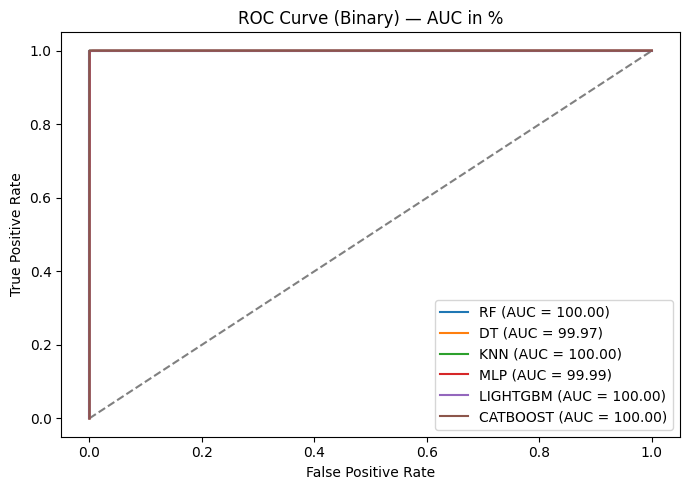

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_ml_roc_models_binary.png
🖼 Curva ROC comparativa guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_ml_roc_models_binary.png
✅ Bloque 8b completado (tabla comparativa + ROC ML binaria/multiclase en %).
⏱ Fin bloque 8b - Comparativo ML y ROC (duración: 0.66 s)


In [39]:
## 8b) Comparativo final de modelos ML + ROC (binaria y multiclase) — v4.4.0
##     Accuracy / Precision / Recall / F1 / AUC en porcentaje en la tabla y en el gráfico (AUC).

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.preprocessing import label_binarize

pd.set_option("display.max_columns", None)

with timed_block("8b - Comparativo ML y ROC"):
    if 'results_ml' not in locals() or not isinstance(results_ml, list) or len(results_ml) == 0:
        msg = ("ℹ️ Bloque 8b omitido: no hay resultados en `results_ml`. "
               "Ejecuta el Bloque 8 antes de este.")
        _append_log(msg)
        print(msg)
    else:
        _append_log("📊 Iniciando comparativo de modelos ML (Bloque 8b)…")

        # 1) Tabla comparativa completa (estilo paper)
        results_df = (
            pd.DataFrame(results_ml)
            .sort_values(by="F1-score (%)", ascending=False)
            .reset_index(drop=True)
        )

        print(results_df)

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_ml_results_comparative.csv")
        save_and_display_table(
            results_df,
            comp_csv,
            note="Comparative metrics of all ML models (sorted by F1-score (%))"
        )

        # 2) Preparar información de clases
        y_true = np.asarray(y_test)
        classes_sorted = np.unique(y_true)
        n_classes = len(classes_sorted)
        is_binary = (n_classes == 2)

        # 3) Construir curvas ROC por modelo (AUC crudo → label en %)
        roc_models = []  # (name, fpr, tpr, auc_val_decimal)
        for row in results_ml:
            name = row.get("Model", "ML")
            y_proba = probas_ml.get(name)

            if y_proba is None:
                _append_log(f"⚠️ ROC: modelo {name} no tiene probabilidades, se omite.")
                continue

            try:
                if is_binary:
                    # ROC binaria clásica
                    if y_proba.ndim != 2 or y_proba.shape[1] < 2:
                        _append_log(f"⚠️ ROC: salida de predict_proba de {name} no es binaria válida.")
                        continue

                    fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1])
                    auc_val = roc_auc_score(y_true, y_proba[:, 1])

                else:
                    # ROC multiclase (micro-average)
                    y_true_bin = label_binarize(y_true, classes=classes_sorted)
                    if y_proba.shape[1] != y_true_bin.shape[1]:
                        _append_log(
                            f"⚠️ ROC: dimensiones proba vs clases no coinciden para {name}. "
                            f"y_proba.shape={y_proba.shape}, y_true_bin.shape={y_true_bin.shape}"
                        )
                        continue

                    fpr, tpr, _ = roc_curve(
                        y_true_bin.ravel(),
                        y_proba.ravel()
                    )
                    auc_val = roc_auc_score(
                        y_true_bin,
                        y_proba,
                        average="micro",
                        multi_class="ovr"
                    )

                roc_models.append((name, fpr, tpr, auc_val))

            except Exception as e:
                _append_log(f"⚠️ ROC: error calculando curva para {name}: {e}")

        # 4) Dibujar gráfico ROC si hay modelos válidos
        if len(roc_models) == 0:
            msg = "ℹ️ No se encontraron modelos con probabilidades válidas para dibujar la ROC."
            _append_log(msg)
            print(msg)
        else:
            plt.figure(figsize=(7, 5))
            plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

            for name, fpr, tpr, auc_val in roc_models:
                label = f"{name} (AUC = {auc_val*100:.2f})"  # AUC en porcentaje
                plt.plot(fpr, tpr, label=label)

            if is_binary:
                title = "ROC Curve (Binary) — AUC in %"
                filename = f"{RUN_TAG}_ml_roc_models_binary.png"
            else:
                title = "ROC Curve (Multiclass, micro-average) — AUC in %"
                filename = f"{RUN_TAG}_ml_roc_models_multiclass.png"

            plt.title(title)
            plt.xlabel("False Positive Rate")
            plt.ylabel("True Positive Rate")
            plt.legend(loc="lower right")

            roc_path = os.path.join(FIG_DIR, filename)
            show_and_save_current_fig(roc_path)
            _append_log(f"🖼 Curva ROC comparativa guardada en: {roc_path}")

        _append_log("✅ Bloque 8b completado (tabla comparativa + ROC ML binaria/multiclase en %).")

## 9) DL: GPU, **mixed precision**, lotes dinámicos + ANN/CNN1D/LSTM/AE+LR

▶️ Inicio bloque 9 - Entrenamiento y evaluación de modelos DL (con checkpoint)
📌 DL: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).
🔢 DL: n_samples_train=46876, n_features=20, n_classes=2, SMOTE_MODE=full.
🔹 DL: iniciando modelo ANN…
♻️ ANN: modelo DL cargado desde checkpoint /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_ANN_DL_final.keras (no se reentrena).
⏩ ANN: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).
✅ ANN: Acc=99.83%, Prec=99.83%, Rec=99.83%, F1=99.83%, MAE=0.001706, MSE=0.001706, RMSE=0.041310, AUC=100.00%, Train=NaN (ckpt), Pred=0.51s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5849,11
1,Malware,9,5851


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_ANN_DL.csv — Confusion matrix for DL model ANN


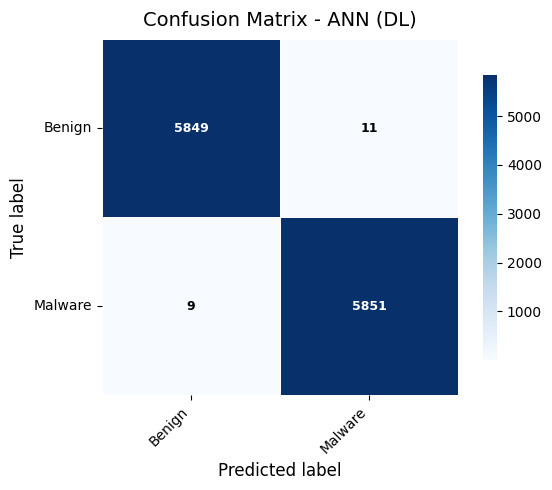

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_ANN_DL.png
🖼 Matriz de confusión DL ANN guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_ANN_DL.png
🔹 DL: iniciando modelo CNN1D…
♻️ CNN1D: modelo DL cargado desde checkpoint /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_CNN1D_DL_final.keras (no se reentrena).
⏩ CNN1D: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).
✅ CNN1D: Acc=99.86%, Prec=99.86%, Rec=99.86%, F1=99.86%, MAE=0.001365, MSE=0.001365, RMSE=0.036948, AUC=99.99%, Train=NaN (ckpt), Pred=0.64s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5851,9
1,Malware,7,5853


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_CNN1D_DL.csv — Confusion matrix for DL model CNN1D


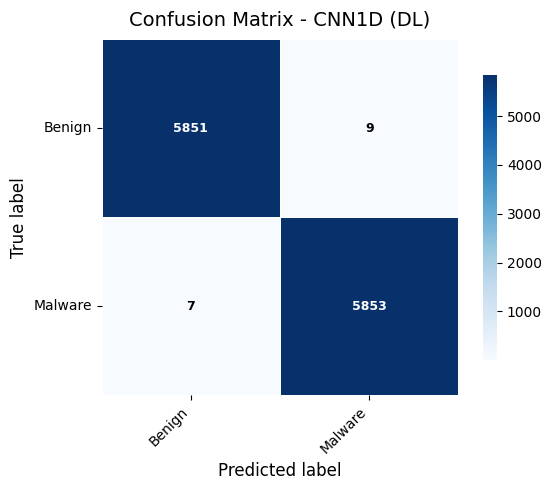

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_CNN1D_DL.png
🖼 Matriz de confusión DL CNN1D guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_CNN1D_DL.png
🔹 DL: iniciando modelo LSTM…
♻️ LSTM: modelo DL cargado desde checkpoint /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_LSTM_DL_final.keras (no se reentrena).
⏩ LSTM: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).
✅ LSTM: Acc=99.71%, Prec=99.71%, Rec=99.71%, F1=99.71%, MAE=0.002901, MSE=0.002901, RMSE=0.053861, AUC=99.99%, Train=NaN (ckpt), Pred=0.32s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5840,20
1,Malware,14,5846


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_LSTM_DL.csv — Confusion matrix for DL model LSTM


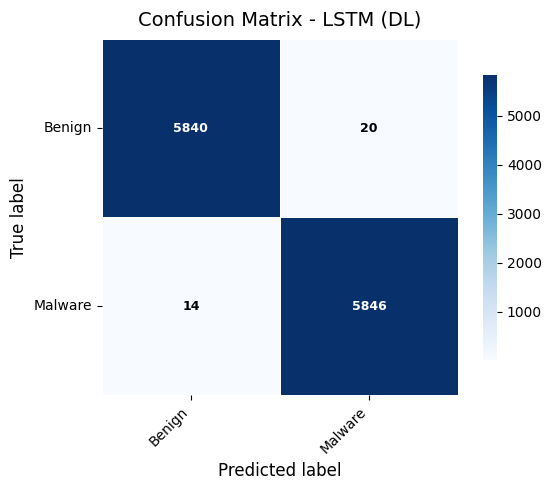

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_LSTM_DL.png
🖼 Matriz de confusión DL LSTM guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_LSTM_DL.png
🔹 DL: iniciando modelo AE_LR…
♻️ AE_LR: modelo DL cargado desde checkpoint /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/checkpoints/MalMem2022_binary_AE_LR_DL_final.keras (no se reentrena).
⏩ AE_LR: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).
✅ AE_LR: Acc=99.88%, Prec=99.88%, Rec=99.88%, F1=99.88%, MAE=0.001195, MSE=0.001195, RMSE=0.034562, AUC=100.00%, Train=NaN (ckpt), Pred=0.72s, SMOTE_MODE=full.


,True\Pred,Benign,Malware
0,Benign,5854,6
1,Malware,8,5852


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_cm_AE_LR_DL.csv — Confusion matrix for DL model AE_LR


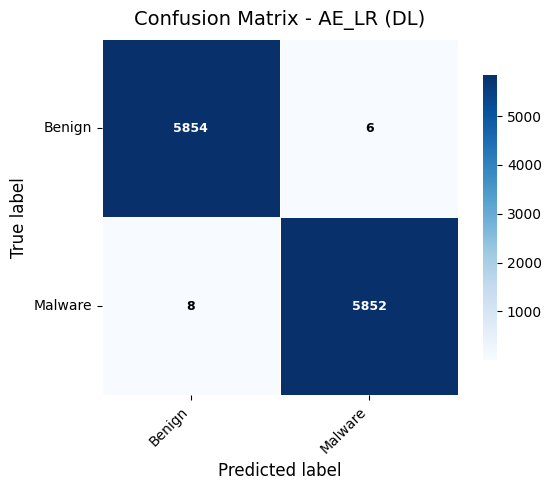

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_AE_LR_DL.png
🖼 Matriz de confusión DL AE_LR guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_cm_AE_LR_DL.png
✅ Bloque 9 completado (DL: entrenamiento/carga, métricas y matrices de confusión).
⏱ Fin bloque 9 - Entrenamiento y evaluación de modelos DL (con checkpoint) (duración: 4.36 s)


In [40]:
## ============================================================
## 9) Modelos Deep Learning (ANN, CNN1D, LSTM, AE_LR) con checkpoint — v6.1
##    - Usa X_train_sel/X_test_sel si existen (Top-N por XGBoost)
##    - Compatible con SMOTE_MODE (full / dynamic / none)
##    - Métricas en porcentaje, errores en escala normal
##    - Matriz de confusión con texto negro/blanco según intensidad
## ============================================================

import os, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    roc_auc_score,
    mean_absolute_error,
    mean_squared_error
)

with timed_block("9 - Entrenamiento y evaluación de modelos DL (con checkpoint)"):

    # ------------------------------------------------------
    # 0) Selección de features (Top-N o todas)
    # ------------------------------------------------------
    if 'X_train_sel' in locals() and 'X_test_sel' in locals():
        Xtr = np.asarray(X_train_sel)
        Xte = np.asarray(X_test_sel)
        _append_log("📌 DL: usando X_train_sel / X_test_sel (Top-N features de Bloque 7).")
    else:
        Xtr = np.asarray(X_train)
        Xte = np.asarray(X_test)
        _append_log("📌 DL: usando X_train / X_test (todas las features).")

    if 'y_train' not in locals() or 'y_test' not in locals():
        raise ValueError("❌ y_train / y_test no definidos. Ejecuta bloques 5 y 6 antes del 9.")

    ytr = np.asarray(y_train, dtype=int)
    yte = np.asarray(y_test, dtype=int)

    n_classes = len(np.unique(ytr))
    is_binary = (n_classes == 2)
    n_features = Xtr.shape[1]

    smote_mode_for_log = globals().get("SMOTE_MODE", "unknown")
    _append_log(
        f"🔢 DL: n_samples_train={Xtr.shape[0]}, n_features={n_features}, "
        f"n_classes={n_classes}, SMOTE_MODE={smote_mode_for_log}."
    )

    # ------------------------------------------------------
    # 1) Etiquetas para Keras
    # ------------------------------------------------------
    if is_binary:
        # Forma (N,1) para evitar problemas con binary_crossentropy
        ytr_keras = ytr.astype("float32").reshape(-1, 1)
        yte_keras = yte.astype("float32").reshape(-1, 1)
        output_units = 1
        output_activation = "sigmoid"
        loss_fn = "binary_crossentropy"
    else:
        ytr_keras = keras.utils.to_categorical(ytr, num_classes=n_classes)
        yte_keras = keras.utils.to_categorical(yte, num_classes=n_classes)
        output_units = n_classes
        output_activation = "softmax"
        loss_fn = "categorical_crossentropy"

    # ------------------------------------------------------
    # 2) Builders de modelos DL clásicos (ANN, CNN1D, LSTM)
    # ------------------------------------------------------
    def build_dl_model(key: str, input_dim: int):
        key = key.upper()
        if key == "ANN":
            inputs = keras.Input(shape=(input_dim,))
            x = keras.layers.Dense(128, activation="relu")(inputs)
            x = keras.layers.Dropout(0.3)(x)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="ANN")

        elif key == "CNN1D":
            inputs = keras.Input(shape=(input_dim, 1))
            x = keras.layers.Conv1D(64, 3, activation="relu", padding="same")(inputs)
            x = keras.layers.MaxPooling1D(2)(x)
            x = keras.layers.Conv1D(64, 3, activation="relu", padding="same")(x)
            x = keras.layers.GlobalMaxPooling1D()(x)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="CNN1D")

        elif key == "LSTM":
            inputs = keras.Input(shape=(input_dim, 1))
            x = keras.layers.LSTM(64, return_sequences=False)(inputs)
            x = keras.layers.Dense(64, activation="relu")(x)
            outputs = keras.layers.Dense(output_units, activation=output_activation)(x)
            model = keras.Model(inputs, outputs, name="LSTM")

        else:
            raise ValueError(f"Modelo DL desconocido (builder clásico): {key}")

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss=loss_fn,
            metrics=["accuracy"]
        )
        return model

    # ------------------------------------------------------
    # 3) Builder específico AE_LR (Autoencoder + cabeza clasificador)
    # ------------------------------------------------------
    def build_ae_lr(input_dim: int):
        """
        Autoencoder + cabeza lineal:
        - 'reconstruction': reconstruye X (MSE)
        - 'classifier': clasifica (binaria o multiclase)
        """
        latent_dim = min(32, max(4, input_dim // 2))

        inp = keras.Input(shape=(input_dim,), name="input")
        # Encoder
        x = keras.layers.Dense(64, activation="relu")(inp)
        bottleneck = keras.layers.Dense(latent_dim, activation="relu", name="bottleneck")(x)

        # Reconstrucción
        dec = keras.layers.Dense(64, activation="relu")(bottleneck)
        recon = keras.layers.Dense(input_dim, activation="linear", name="reconstruction")(dec)

        # Clasificador
        cls = keras.layers.Dense(32, activation="relu")(bottleneck)
        clf_out = keras.layers.Dense(output_units, activation=output_activation, name="classifier")(cls)

        model = keras.Model(
            inputs=inp,
            outputs={"reconstruction": recon, "classifier": clf_out},
            name="AE_LR"
        )

        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=1e-3),
            loss={
                "reconstruction": "mse",
                "classifier": loss_fn
            },
            loss_weights={"reconstruction": 0.5, "classifier": 1.0},
            metrics={"classifier": ["accuracy"]}
        )
        return model

    # ------------------------------------------------------
    # 4) Datos 3D para CNN/LSTM
    # ------------------------------------------------------
    Xtr_seq = Xtr.reshape((Xtr.shape[0], n_features, 1))
    Xte_seq = Xte.reshape((Xte.shape[0], n_features, 1))

    # ------------------------------------------------------
    # 5) Callbacks (EarlyStopping + ModelCheckpoint)
    # ------------------------------------------------------
    def make_callbacks(model_name: str):
        best_ckpt_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{model_name}_DL_best.weights.h5")
        es = keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=3,
            restore_best_weights=True
        )
        mc = keras.callbacks.ModelCheckpoint(
            best_ckpt_path,
            monitor="val_loss",
            save_best_only=True,
            save_weights_only=True,
            verbose=0
        )
        return [es, mc], best_ckpt_path

    results_dl = []
    probas_dl = {}

    # ------------------------------------------------------
    # 6) Loop principal DL_TO_RUN
    # ------------------------------------------------------
    for key in DL_TO_RUN:
        dl_name = key.upper()
        _append_log(f"🔹 DL: iniciando modelo {dl_name}…")

        if dl_name in ("CNN1D", "LSTM"):
            Xtrain_used = Xtr_seq
            Xtest_used = Xte_seq
        else:
            Xtrain_used = Xtr
            Xtest_used = Xte

        final_model_path = os.path.join(CKPT_DIR, f"{RUN_TAG}_{dl_name}_DL_final.keras")

        model = None
        loaded_from_ckpt = False
        t_train = np.nan

        # 6.1 Intentar cargar modelo desde checkpoint
        if os.path.exists(final_model_path):
            try:
                model = keras.models.load_model(final_model_path)
                loaded_from_ckpt = True
                _append_log(
                    f"♻️ {dl_name}: modelo DL cargado desde checkpoint {final_model_path} "
                    "(no se reentrena)."
                )
            except Exception as e:
                _append_log(
                    f"⚠️ {dl_name}: error al cargar modelo desde {final_model_path} ({e}). "
                    "Se procederá a reentrenar."
                )
                model = None
                loaded_from_ckpt = False

        # 6.2 Si no hay modelo guardado → entrenar
        if model is None:
            if dl_name == "AE_LR":
                model = build_ae_lr(input_dim=n_features)
            else:
                model = build_dl_model(dl_name, input_dim=n_features)

            callbacks, best_ckpt_path = make_callbacks(dl_name)

            batch_size = 256
            epochs = 20

            t0 = time.time()
            if dl_name == "AE_LR":
                # Targets para la cabeza classifier del AE
                if is_binary:
                    ytr_cls = ytr.astype("float32").reshape(-1, 1)
                    yte_cls = yte.astype("float32").reshape(-1, 1)
                else:
                    ytr_cls = ytr_keras
                    yte_cls = yte_keras

                history = model.fit(
                    Xtrain_used,
                    {"reconstruction": Xtrain_used, "classifier": ytr_cls},
                    validation_data=(
                        Xtest_used,
                        {"reconstruction": Xtest_used, "classifier": yte_cls}
                    ),
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=0
                )
            else:
                history = model.fit(
                    Xtrain_used,
                    ytr_keras,
                    validation_split=0.2,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks,
                    verbose=0
                )
            t_train = time.time() - t0

            _append_log(
                f"✅ {dl_name}: entrenamiento finalizado en {t_train:.2f} s "
                f"({len(history.history['loss'])} épocas efectivas)."
            )

            # Restaurar mejores pesos
            try:
                model.load_weights(best_ckpt_path)
                _append_log(f"💾 {dl_name}: pesos restaurados desde {best_ckpt_path}.")
            except Exception as e:
                _append_log(f"⚠️ {dl_name}: no se pudieron cargar pesos desde {best_ckpt_path} ({e}).")

            # Guardar modelo final
            try:
                model.save(final_model_path)
                record_model(f"{RUN_TAG}_{dl_name}_DL", final_model_path)
                _append_log(f"💾 Modelo DL {dl_name} guardado en: {final_model_path}")
            except Exception as e:
                _append_log(f"⚠️ {dl_name}: no se pudo guardar el modelo DL completo ({e}).")
        else:
            _append_log(f"⏩ {dl_name}: usando modelo DL ya entrenado (t_train_s=NaN, ckpt).")

        # ------------------------------------------------------
        # 7) Predicción
        # ------------------------------------------------------
        batch_size = 256
        t1 = time.time()
        if dl_name == "AE_LR":
            preds = model.predict(Xtest_used, batch_size=batch_size, verbose=0)
            # Para modelos funcionales con dict de salidas
            y_proba_raw = preds["classifier"]
        else:
            y_proba_raw = model.predict(Xtest_used, batch_size=batch_size, verbose=0)
        t_pred = time.time() - t1

        # ------------------------------------------------------
        # 8) Probabilidades → etiquetas
        # ------------------------------------------------------
        if is_binary:
            y_scores = y_proba_raw.ravel()
            y_pred = (y_scores >= 0.5).astype(int)
            y_proba_for_auc = np.stack([1 - y_scores, y_scores], axis=1)
        else:
            y_pred = np.argmax(y_proba_raw, axis=1)
            y_proba_for_auc = y_proba_raw

        # ------------------------------------------------------
        # 9) Métricas
        # ------------------------------------------------------
        acc = accuracy_score(yte, y_pred)
        prec, rec, f1, _ = precision_recall_fscore_support(
            yte, y_pred,
            average='macro',
            zero_division=0
        )

        mae = mean_absolute_error(yte, y_pred)
        mse = mean_squared_error(yte, y_pred)
        rmse = np.sqrt(mse)

        auc_val = None
        try:
            if is_binary:
                auc_val = roc_auc_score(yte, y_proba_for_auc[:, 1])
            else:
                auc_val = roc_auc_score(
                    yte,
                    y_proba_for_auc,
                    multi_class='ovr',
                    average='macro'
                )
        except Exception as e:
            _append_log(f"⚠️ {dl_name}: error al calcular AUC ({e}).")
            auc_val = None

        # 10) Convertir a porcentaje
        acc_pct = acc * 100
        prec_pct = prec * 100
        rec_pct  = rec * 100
        f1_pct   = f1 * 100
        auc_pct  = auc_val * 100 if auc_val is not None else None

        results_dl.append({
            "Model": dl_name,
            "Accuracy (%)": acc_pct,
            "Precision (%)": prec_pct,
            "Recall (%)": rec_pct,
            "F1-score (%)": f1_pct,
            "MAE": mae,
            "MSE": mse,
            "RMSE": rmse,
            "AUC (%)": auc_pct,
            "Train_time_s": t_train,
            "Predict_time_s": t_pred,
            "Loaded_from_ckpt": loaded_from_ckpt,
            "SMOTE_MODE": smote_mode_for_log
        })
        probas_dl[dl_name] = y_proba_for_auc

        _append_log(
            f"✅ {dl_name}: Acc={acc_pct:.2f}%, Prec={prec_pct:.2f}%, Rec={rec_pct:.2f}%, "
            f"F1={f1_pct:.2f}%, MAE={mae:.6f}, MSE={mse:.6f}, RMSE={rmse:.6f}, "
            f"AUC={'%.2f%%' % auc_pct if auc_pct is not None else 'N/A'}, "
            f"Train={'NaN (ckpt)' if np.isnan(t_train) else f'{t_train:.2f}s'}, "
            f"Pred={t_pred:.2f}s, SMOTE_MODE={smote_mode_for_log}."
        )

        # ------------------------------------------------------
        # 11) Matriz de confusión con texto adaptativo (negro/blanco)
        # ------------------------------------------------------
        cm = confusion_matrix(yte, y_pred)
        cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

        cm_csv = os.path.join(REP_DIR, f"{RUN_TAG}_cm_{dl_name}_DL.csv")
        save_and_display_table(
            cm_df.reset_index().rename(columns={'index': 'True\\Pred'}),
            cm_csv,
            note=f"Confusion matrix for DL model {dl_name}"
        )

        fig, ax = plt.subplots(figsize=(6, 5))
        sns.heatmap(
            cm,
            annot=True,
            fmt='d',
            cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names,
            square=True,
            linewidths=0.5,
            linecolor='white',
            cbar_kws={"shrink": 0.8},
            ax=ax,
            annot_kws={"fontsize": 9, "fontweight": "bold"}
        )

        ax.set_title(f"Confusion Matrix - {dl_name} (DL)", fontsize=14, pad=10)
        ax.set_xlabel("Predicted label", fontsize=12)
        ax.set_ylabel("True label", fontsize=12)

        ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', fontsize=10)
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0, fontsize=10)

        # Umbral para cambiar color del texto
        threshold = cm.max() / 2.0 if cm.max() > 0 else 0

        for text in ax.texts:
            x, y_pos = text.get_position()  # (col+0.5, fila+0.5)
            j = int(round(x - 0.5))
            i = int(round(y_pos - 0.5))
            value = cm[i, j]
            if value > threshold:
                text.set_color("white")
            else:
                text.set_color("black")
            text.set_fontweight("bold")

        fig.tight_layout()
        cm_fig_path = os.path.join(FIG_DIR, f"{RUN_TAG}_cm_{dl_name}_DL.png")
        show_and_save_current_fig(cm_fig_path)
        _append_log(f"🖼 Matriz de confusión DL {dl_name} guardada en: {cm_fig_path}")

        # ------------------------------------------------------
        # 12) Registrar en resumen global
        # ------------------------------------------------------
        log_result({
            "block": "9_dl",
            "dataset": DATASET,
            "task_mode": TASK_MODE,
            "model": dl_name,
            "accuracy_pct": acc_pct,
            "precision_pct": prec_pct,
            "recall_pct": rec_pct,
            "f1_pct": f1_pct,
            "mae": mae,
            "mse": mse,
            "rmse": rmse,
            "auc_pct": auc_pct,
            "train_time_s": t_train,
            "predict_time_s": t_pred,
            "loaded_from_ckpt": loaded_from_ckpt,
            "smote_mode": smote_mode_for_log
        })

    _append_log("✅ Bloque 9 completado (DL: entrenamiento/carga, métricas y matrices de confusión).")


## BLOQUE 9b — Comparativo DL + ROC comparativa (solo binario)

▶️ Inicio bloque 9b - Comparativo DL y ROC
📊 Iniciando comparativo de modelos DL (Bloque 9b)…
   Model  Accuracy (%)  Precision (%)  Recall (%)  F1-score (%)       MAE  \
0  AE_LR     99.880546      99.880552   99.880546     99.880546  0.001195   
1  CNN1D     99.863481      99.863487   99.863481     99.863481  0.001365   
2    ANN     99.829352      99.829357   99.829352     99.829352  0.001706   
3   LSTM     99.709898      99.709950   99.709898     99.709898  0.002901   

        MSE      RMSE    AUC (%)  Train_time_s  Predict_time_s  \
0  0.001195  0.034562  99.998768           NaN        0.724242   
1  0.001365  0.036948  99.985731           NaN        0.635318   
2  0.001706  0.041310  99.996820           NaN        0.513079   
3  0.002901  0.053861  99.994123           NaN        0.324224   

   Loaded_from_ckpt SMOTE_MODE  
0              True       full  
1              True       full  
2              True       full  
3              True       full  


,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),MAE,MSE,RMSE,AUC (%),Train_time_s,Predict_time_s,Loaded_from_ckpt,SMOTE_MODE
0,AE_LR,99.880546,99.880552,99.880546,99.880546,0.001195,0.001195,0.034562,99.998768,NaN,0.724242,True,full
1,CNN1D,99.863481,99.863487,99.863481,99.863481,0.001365,0.001365,0.036948,99.985731,NaN,0.635318,True,full
2,ANN,99.829352,99.829357,99.829352,99.829352,0.001706,0.001706,0.041310,99.996820,NaN,0.513079,True,full
3,LSTM,99.709898,99.709950,99.709898,99.709898,0.002901,0.002901,0.053861,99.994123,NaN,0.324224,True,full


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_dl_results_comparative.csv — Comparative metrics of all DL models (sorted by F1-score (%))


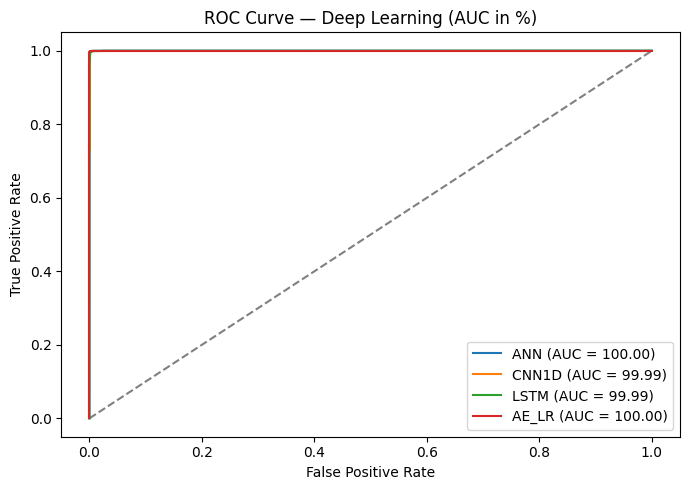

📊 Gráfico guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_dl_roc_models.png
🖼 Curva ROC DL comparativa guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/figs/MalMem2022_binary_dl_roc_models.png
✅ Bloque 9b completado (tabla comparativa + ROC DL si aplica, AUC en %).
⏱ Fin bloque 9b - Comparativo DL y ROC (duración: 0.91 s)


In [41]:
## 9b) Comparativo final de modelos DL + ROC — v4.4.0
##     Accuracy / Precision / Recall / F1 / AUC en porcentaje.

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

pd.set_option("display.max_columns", None)

with timed_block("9b - Comparativo DL y ROC"):
    if 'results_dl' not in locals() or not isinstance(results_dl, list) or len(results_dl) == 0:
        msg = ("ℹ️ Bloque 9b omitido: no hay resultados en `results_dl`. "
               "Ejecuta el Bloque 9 antes de este.")
        _append_log(msg)
        print(msg)
    else:
        _append_log("📊 Iniciando comparativo de modelos DL (Bloque 9b)…")

        results_df = (
            pd.DataFrame(results_dl)
            .sort_values(by="F1-score (%)", ascending=False)
            .reset_index(drop=True)
        )

        print(results_df)

        comp_csv = os.path.join(REP_DIR, f"{RUN_TAG}_dl_results_comparative.csv")
        save_and_display_table(
            results_df,
            comp_csv,
            note="Comparative metrics of all DL models (sorted by F1-score (%))"
        )

        # ROC solo si tarea binaria
        n_classes = len(np.unique(y_test))
        is_binary = (n_classes == 2)

        if not is_binary:
            msg = (f"ℹ️ Tarea multiclase (n_clases={n_classes}): "
                   "este bloque solo dibuja ROC comparativa para tareas binarias. "
                   "Se omite el gráfico ROC DL.")
            _append_log(msg)
            print(msg)
        else:
            roc_models = []
            for row in results_dl:
                name = row.get("Model", "DL")
                y_proba = probas_dl.get(name)
                if y_proba is None:
                    _append_log(f"⚠️ ROC DL: modelo {name} no tiene probabilidades; se omite.")
                    continue
                if y_proba.ndim != 2 or y_proba.shape[1] < 2:
                    _append_log(f"⚠️ ROC DL: salida de predict_proba de {name} no es binaria; se omite.")
                    continue

                try:
                    fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                    auc_val = roc_auc_score(y_test, y_proba[:, 1])
                    roc_models.append((name, fpr, tpr, auc_val))
                except Exception as e:
                    _append_log(f"⚠️ ROC DL: error calculando curva para {name}: {e}")

            if len(roc_models) == 0:
                msg = "ℹ️ No se encontraron modelos DL con probabilidades válidas para ROC."
                _append_log(msg)
                print(msg)
            else:
                plt.figure(figsize=(7, 5))
                plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

                for name, fpr, tpr, auc_val in roc_models:
                    label = f"{name} (AUC = {auc_val*100:.2f})"
                    plt.plot(fpr, tpr, label=label)

                plt.title("ROC Curve — Deep Learning (AUC in %)")
                plt.xlabel("False Positive Rate")
                plt.ylabel("True Positive Rate")
                plt.legend(loc="lower right")

                roc_path = os.path.join(FIG_DIR, f"{RUN_TAG}_dl_roc_models.png")
                show_and_save_current_fig(roc_path)
                _append_log(f"🖼 Curva ROC DL comparativa guardada en: {roc_path}")

        _append_log("✅ Bloque 9b completado (tabla comparativa + ROC DL si aplica, AUC en %).")

## 10) Resumen final del experimento

In [42]:
## 10) Resumen final y exportación consolidada — v4.4.0
## Integra resultados de ML (bloque 8) y DL (bloque 9) en una sola tabla estilo paper.

import os
import pandas as pd

with timed_block("10 - Resumen final de resultados (ML + DL)"):
    summary_rows = []

    # 1) Agregar resultados de modelos ML, si existen
    if 'results_ml' in locals() and isinstance(results_ml, list) and len(results_ml) > 0:
        for row in results_ml:
            r = dict(row)  # copia
            r["Family"] = "ML"
            summary_rows.append(r)
        _append_log(f"📚 Bloque 10: agregados {len(results_ml)} modelos ML al resumen.")
    else:
        _append_log("ℹ️ Bloque 10: no se encontraron resultados_ml (bloque 8 no ejecutado o sin modelos).")

    # 2) Agregar resultados de modelos DL, si existen
    if 'results_dl' in locals() and isinstance(results_dl, list) and len(results_dl) > 0:
        for row in results_dl:
            r = dict(row)  # copia
            r["Family"] = "DL"
            summary_rows.append(r)
        _append_log(f"📚 Bloque 10: agregados {len(results_dl)} modelos DL al resumen.")
    else:
        _append_log("ℹ️ Bloque 10: no se encontraron resultados_dl (bloque 9 no ejecutado o sin modelos).")

    # 3) Si no hay nada, salir con mensaje amigable
    if not summary_rows:
        msg = ("⚠️ Bloque 10: no hay resultados de ML ni DL para resumir. "
               "Ejecuta los bloques 8 y/o 9 antes de este bloque.")
        _append_log(msg)
        print(msg)
    else:
        # 4) Construir DataFrame consolidado
        summary_df = pd.DataFrame(summary_rows)

        # Ordenar columnas en un orden lógico estilo paper
        col_order = [
            "Family",
            "Model",
            "Accuracy (%)",
            "Precision (%)",
            "Recall (%)",
            "F1-score (%)",
            "AUC (%)",
            "MAE",
            "MSE",
            "RMSE",
            "Train_time_s",
            "Predict_time_s",
            "Loaded_from_ckpt"
        ]

        # Mantener solo columnas que existan (por si algo cambió)
        col_order = [c for c in col_order if c in summary_df.columns]
        summary_df = summary_df[col_order].sort_values(
            by=["Family", "F1-score (%)"] if "F1-score (%)" in summary_df.columns else ["Family", "Model"],
            ascending=[True, False]
        ).reset_index(drop=True)

        # 5) Guardar en la carpeta de reports del RUN_TAG
        summary_csv = os.path.join(REP_DIR, f"{RUN_TAG}_summary_all_models.csv")
        save_and_display_table(
            summary_df,
            summary_csv,
            note=(
                "Consolidated summary of ML and DL models "
                "(metrics in percentage for Accuracy/Precision/Recall/F1/AUC)."
            )
        )

        print("📊 Resumen consolidado de modelos (ML + DL):")
        display(summary_df)

        _append_log(
            "✅ Bloque 10 completado: resumen consolidado guardado en: "
            f"{summary_csv}"
        )

▶️ Inicio bloque 10 - Resumen final de resultados (ML + DL)
📚 Bloque 10: agregados 6 modelos ML al resumen.
📚 Bloque 10: agregados 4 modelos DL al resumen.


,Family,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),MAE,MSE,RMSE,Train_time_s,Predict_time_s,Loaded_from_ckpt
0,DL,AE_LR,99.880546,99.880552,99.880546,99.880546,99.998768,0.001195,0.001195,0.034562,NaN,0.724242,True
1,DL,CNN1D,99.863481,99.863487,99.863481,99.863481,99.985731,0.001365,0.001365,0.036948,NaN,0.635318,True
2,DL,ANN,99.829352,99.829357,99.829352,99.829352,99.996820,0.001706,0.001706,0.041310,NaN,0.513079,True
3,DL,LSTM,99.709898,99.709950,99.709898,99.709898,99.994123,0.002901,0.002901,0.053861,NaN,0.324224,True
4,ML,LIGHTGBM,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,1.110446,0.031938,True
5,ML,CATBOOST,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,1.791477,0.006315,True
6,ML,RF,99.991468,99.991469,99.991468,99.991468,100.000000,0.000085,0.000085,0.009237,2.435113,0.077481,True
7,ML,DT,99.974403,99.974404,99.974403,99.974403,99.974403,0.000256,0.000256,0.015999,0.236340,0.001292,True
8,ML,KNN,99.940273,99.940286,99.940273,99.940273,99.999959,0.000597,0.000597,0.024439,0.007712,0.895873,True
9,ML,MLP,99.820819,99.820855,99.820819,99.820819,99.987364,0.001792,0.001792,0.042330,20.031757,0.013241,True


📄 Tabla guardada en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_summary_all_models.csv — Consolidated summary of ML and DL models (metrics in percentage for Accuracy/Precision/Recall/F1/AUC).
📊 Resumen consolidado de modelos (ML + DL):


,Family,Model,Accuracy (%),Precision (%),Recall (%),F1-score (%),AUC (%),MAE,MSE,RMSE,Train_time_s,Predict_time_s,Loaded_from_ckpt
0,DL,AE_LR,99.880546,99.880552,99.880546,99.880546,99.998768,0.001195,0.001195,0.034562,NaN,0.724242,True
1,DL,CNN1D,99.863481,99.863487,99.863481,99.863481,99.985731,0.001365,0.001365,0.036948,NaN,0.635318,True
2,DL,ANN,99.829352,99.829357,99.829352,99.829352,99.996820,0.001706,0.001706,0.041310,NaN,0.513079,True
3,DL,LSTM,99.709898,99.709950,99.709898,99.709898,99.994123,0.002901,0.002901,0.053861,NaN,0.324224,True
4,ML,LIGHTGBM,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,1.110446,0.031938,True
5,ML,CATBOOST,100.000000,100.000000,100.000000,100.000000,100.000000,0.000000,0.000000,0.000000,1.791477,0.006315,True
6,ML,RF,99.991468,99.991469,99.991468,99.991468,100.000000,0.000085,0.000085,0.009237,2.435113,0.077481,True
7,ML,DT,99.974403,99.974404,99.974403,99.974403,99.974403,0.000256,0.000256,0.015999,0.236340,0.001292,True
8,ML,KNN,99.940273,99.940286,99.940273,99.940273,99.999959,0.000597,0.000597,0.024439,0.007712,0.895873,True
9,ML,MLP,99.820819,99.820855,99.820819,99.820819,99.987364,0.001792,0.001792,0.042330,20.031757,0.013241,True


✅ Bloque 10 completado: resumen consolidado guardado en: /content/drive/MyDrive/Colab Notebooks/ids_pipeline_full_smote/MalMem2022_binary/reports/MalMem2022_binary_summary_all_models.csv
⏱ Fin bloque 10 - Resumen final de resultados (ML + DL) (duración: 0.07 s)
